# NBA Team Analytics Pipeline

## Necessary Imports

In [1]:
import random as rnd
import time
import re
from PIL import Image
import requests
import urllib
import urllib.request
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5g}'.format)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import  OffsetImage
from matplotlib import cm 

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

## Webscrape and Clean NBA Team Data into Pandas DF

In [3]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA

df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS 

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))

# ADD OPONENTS RECORD ON GAME DATE
# ADD TEAM RECORD ON GAME DATE

df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION             TEAM_NAME     GAME_ID  \
0     22022  1610612742               DAL      Dallas Mavericks  0022200734   
1     22022  1610612746               LAC  Los Angeles Clippers  0022200735   
2     22022  1610612759               SAS     San Antonio Spurs  0022200735   
3     22022  1610612756               PHX          Phoenix Suns  0022200734   
4     22022  1610612738               BOS        Boston Celtics  0022200730   

    GAME_DATE      MATCHUP WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  \
0  2023-01-26    DAL @ PHX  W  240   33   77   0.429    13    34    0.382   
1  2023-01-26  LAC vs. SAS  W  240   52   89   0.584    18    38    0.474   
2  2023-01-26    SAS @ LAC  L  240   37   82   0.451     8    24    0.333   
3  2023-01-26  PHX vs. DAL  L  240   35   86   0.407    13    32    0.406   
4  2023-01-26  BOS vs. NYK  L  265   41  100    0.41    16    46    0.348   

   FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0   20   28   0.714     7    36   43   20    3    3    9  10   99           4   
1   16   21   0.762     6    31   37   26    9    9    5  21  138          38   
2   18   28   0.643    11    31   42   24    2    1   14  18  100         -38   
3   12   16    0.75    13    37   50   24    4    6    9  21   95          -4   
4   19   23   0.826    15    39   54   22    4    4   13  19  117          -3   

   FG2M  FG2A  FG2_PTS  FG3_PTS  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  \
0    20    43       40       39       0.55844       0.44156      0.60606   
1    34    51       68       54       0.57303       0.42697      0.65385   
2    29    58       58       24       0.70732       0.29268      0.78378   
3    22    54       44       39       0.62791       0.37209      0.62857   
4    25    54       50       48          0.54          0.46      0.60976   

   FRAC_MK_3PT  FRAC_PTS_2PT  FRAC_PTS_3PT  FRAC_PTS_FT OPP_TEAM_ABBR  \
0      0.39394       0.40404       0.39394      0.20202           PHX   
1      0.34615       0.49275        0.3913      0.11594           SAS   
2      0.21622          0.58          0.24         0.18           LAC   
3      0.37143       0.46316       0.41053      0.12632           DAL   
4      0.39024       0.42735       0.41026      0.16239           NYK   

   OPP_PTS  MONTH  YEAR HOME_AWAY CONFERENCE OPP_CONFERENCE   DATE_MATCHUP  
0       95      1  2023      AWAY       WEST           WEST    01-26 @ PHX  
1      100      1  2023      HOME       WEST           WEST  01-26 vs. SAS  
2      138      1  2023      AWAY       WEST           WEST    01-26 @ LAC  
3       99      1  2023      HOME       WEST           WEST  01-26 vs. DAL  
4      120      1  2023      HOME       EAST           EAST  01-26 vs. NYK

In [4]:
ids = list(df.TEAM_ID.unique())
teams = list(df.TEAM_NAME.unique())

for i in range(len(teams)):
    team_id_dict[teams[i]]=ids[i]

## Create team averages dataframes for offense and defense

In [5]:
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME','TEAM_ABBREVIATION'], aggfunc = 'mean')
df_team_avg = pivot_team_avg.reset_index()
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME','TEAM_ABBREVIATION'], axis=1).mean()
df_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
df_team_avg = df_team_avg.drop(['MONTH','YEAR'],axis=1)
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]

df_team_avg.head()

TEAM_NAME TEAM_ABBR    PTS    AST    BLK   DREB   FG2A   FG2M  \
0      Atlanta Hawks       ATL 116.06 24.204      5 33.245     61 33.224   
1     Boston Celtics       BOS 117.62  26.48   5.36  34.94  46.74  26.34   
2      Brooklyn Nets       BKN 114.27 26.292 6.9167 32.792 52.771 30.604   
3  Charlotte Hornets       CHA 112.02  25.16   4.96  32.96  59.42  31.06   
4      Chicago Bulls       CHI 114.23 24.167  4.625 33.771 58.688 32.125   

   FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  FG_PCT  \
0   66.449 30.653 10.592  0.34806   31.776 91.653 43.816 0.47982   
1    52.68  41.74  15.46  0.36922    46.38  88.48   41.8 0.47378   
2   61.208 31.229 12.188  0.39027   36.562     84 42.792 0.51038   
3    62.12  33.02   10.7  0.32134     32.1  92.44  41.76 0.45292   
4    64.25 29.021 10.562   0.3584   31.688 87.708 42.688 0.48731   

   FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0       0.66433       0.33567      0.75566      0.24434       0.57166   
1        0.5275        0.4725      0.63016      0.36984       0.44806   
2       0.62704       0.37296      0.71432      0.28568       0.53527   
3       0.64329       0.35671      0.74429      0.25571       0.55599   
4       0.66817       0.33183      0.75294      0.24706       0.56423   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.27437      0.15396 21.776 17.837 0.81982 242.55   116.49 10.163   
1       0.39302      0.15892   22.4  18.56  0.8333    243   112.12   9.74   
2       0.31935      0.14539 20.917   16.5 0.79054 240.52    111.6  7.625   
3       0.28411       0.1599   23.7   17.8 0.74684    243   118.62     12   
4       0.27574      0.16003 22.438 18.292 0.80977  242.6   114.65 8.6875   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV  
0 19.122    -0.42857 43.408 6.9184 1.6106e+09 13.061  
1  18.88         5.5  44.68    6.4 1.6106e+09  13.56  
2     22      2.6667 40.417      7 1.6106e+09 14.688  
3   21.1        -6.6  44.96   7.98 1.6106e+09  13.72  
4  19.75    -0.41667 42.458 7.6458 1.6106e+09 13.646

In [6]:
pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc = 'mean')
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBREVIATION'})
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR','TEAM_ID'], axis=1)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_'+x, inplace=True)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBR','OPP_TEAM_NAME':'TEAM_NAME'})


# Optional: Merge Offensive and Defensive Avg DFs
'''
df_team_avg = pd.merge(df_team_avg, 
                       df_defense_allowed_team_avg,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_avg = df_team_avg.drop(['TEAM_NAME_y', 'OPP_PTS_y'],axis=1)
df_team_avg = df_team_avg.rename(columns={'TEAM_NAME_x':'TEAM_NAME','OPP_PTS_x':'OPP_PTS'})
'''

df_defense_allowed_team_avg.head()

TEAM_NAME TEAM_ABBR  OPP_AST  OPP_BLK  OPP_DREB  OPP_FG2A  \
0      Atlanta Hawks       ATL   25.735        5    34.755    57.306   
1      Brooklyn Nets       BKN   23.208   3.7917    32.312    55.562   
2     Boston Celtics       BOS    22.54     3.88     34.16     57.58   
3  Charlotte Hornets       CHA     26.6     6.02     35.46     53.76   
4      Chicago Bulls       CHI    26.25   5.1667    34.271    51.458   

   OPP_FG2M  OPP_FG2_PTS  OPP_FG3A  OPP_FG3M  OPP_FG3_PCT  OPP_FG3_PTS  \
0    31.551       63.102    33.082    11.429      0.34433       34.286   
1    27.938       55.875    32.792    12.062      0.36679       36.188   
2     30.54        61.08      32.6     11.64      0.35744        34.92   
3     29.98        59.96     35.54     13.02      0.36234        39.06   
4      28.5           57    36.667    13.208      0.35921       39.625   

   OPP_FGA  OPP_FGM  OPP_FG_PCT  OPP_FRAC_ATT_2PT  OPP_FRAC_ATT_3PT  \
0   90.388    42.98      0.4772            0.6342            0.3658   
1   88.354       40     0.45333           0.62686           0.37314   
2    90.18    42.18     0.46892           0.63862           0.36138   
3     89.3       43     0.48276           0.60152           0.39848   
4   88.125   41.708     0.47525            0.5839            0.4161   

   OPP_FRAC_MK_2PT  OPP_FRAC_MK_3PT  OPP_FRAC_PTS_2PT  OPP_FRAC_PTS_3PT  \
0          0.73525          0.26475           0.54255           0.29221   
1          0.69613          0.30387            0.5018           0.32337   
2          0.72345          0.27655           0.54617           0.31021   
3          0.69676          0.30324            0.5077           0.32671   
4          0.68297          0.31703            0.4988           0.34457   

   OPP_FRAC_PTS_FT  OPP_FTA  OPP_FTM  OPP_FT_PCT  OPP_MIN  OPP_MONTH  \
0          0.16524   23.837   19.102     0.79771   242.55     8.4898   
1          0.17483   25.292   19.542     0.77135   240.52      8.625   
2          0.14361    20.64    16.12     0.77948      243       8.36   
3           0.1656    24.86     19.6     0.79482      243       8.58   
4          0.15664   23.229   18.021     0.77562    242.6     8.6667   

   OPP_OPP_PTS  OPP_OREB  OPP_PF  OPP_PLUS_MINUS  OPP_PTS  OPP_REB  OPP_STL  \
0       116.06    11.286  20.122         0.42857   116.49   46.041    7.449   
1       114.27    11.542  18.396         -2.6667    111.6   43.854   7.5833   
2       117.62      9.68   19.56            -5.5   112.12    43.84     6.52   
3       112.02      10.7   20.78             6.6   118.62    46.16     6.48   
4       114.23    9.7708      19         0.41667   114.65   44.042   6.6042   

   OPP_TOV  
0   14.755  
1   14.062  
2    12.94  
3    15.12  
4   15.021

## Advanced Shooting Analytics Dataframe

In [7]:
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

df_team_advshot = tables[12]
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

df_team_advshot = df_team_advshot.rename(columns={' 1 Team':'TEAM_NAME',
                                                  ' 2 G':'G',
                                                  ' 3 MP':'MP',
                                                  ' 4 FG%':'FG%',
                                                  ' 5 Dist.':'Dist'})


df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR']=df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]


df_team_advshot.head()

TEAM_NAME TEAM_ABBR   G     MP   FG%  Dist  \
0      Atlanta Hawks       ATL  49  11885 0.476  13.2   
1     Boston Celtics       BOS  50  12150 0.468  14.3   
2      Brooklyn Nets       BKN  48  11545 0.453  13.4   
3      Chicago Bulls       CHI  48  11645 0.473  14.3   
4  Charlotte Hornets       CHA  50  12150 0.482  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.634                     0.293   
1                    0.639                     0.206   
2                    0.629                     0.264   
3                    0.584                     0.274   
4                    0.602                     0.258   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.175                         0.1   
1                      0.223                       0.114   
2                      0.213                       0.087   
3                      0.165                       0.084   
4                      0.187                       0.092   

   % of FGA by Distance 16-3P  % of FGA by Distance 3P  FG% by Distance 2P  \
0                       0.066                    0.366               0.551   
1                       0.095                    0.361                0.53   
2                       0.064                    0.371               0.503   
3                       0.061                    0.416               0.554   
4                       0.065                    0.398               0.558   

   FG% by Distance 0-3  FG% by Distance 3-10  FG% by Distance 10-16  \
0                0.692                 0.437                  0.426   
1                0.681                 0.458                  0.444   
2                0.665                 0.388                  0.388   
3                0.689                 0.456                  0.433   
4                0.683                 0.459                  0.467   

   FG% by Distance 16-3P  FG% by Distance 3P  % of FG Ast'd 2P  \
0                  0.412               0.345             0.507   
1                  0.477               0.357             0.447   
2                  0.369               0.368             0.477   
3                  0.375                0.36             0.528   
4                  0.474               0.366             0.515   

   % of FG Ast'd 3P  Dunks %FGA  Dunks Md.  Layups %FGA  Layups Md.  \
0             0.852       0.069        282        0.288         728   
1             0.763       0.051        209        0.273         671   
2             0.819       0.052        204        0.301         669   
3             0.849       0.063        244        0.266         656   
4             0.857       0.065        241        0.268         657   

   Corner %3PA  Corner 3P%  
0         0.24       0.383  
1        0.174       0.378  
2         0.23       0.401  
3        0.243       0.332  
4        0.254       0.416

## Function Field Goal Trends based on Distance

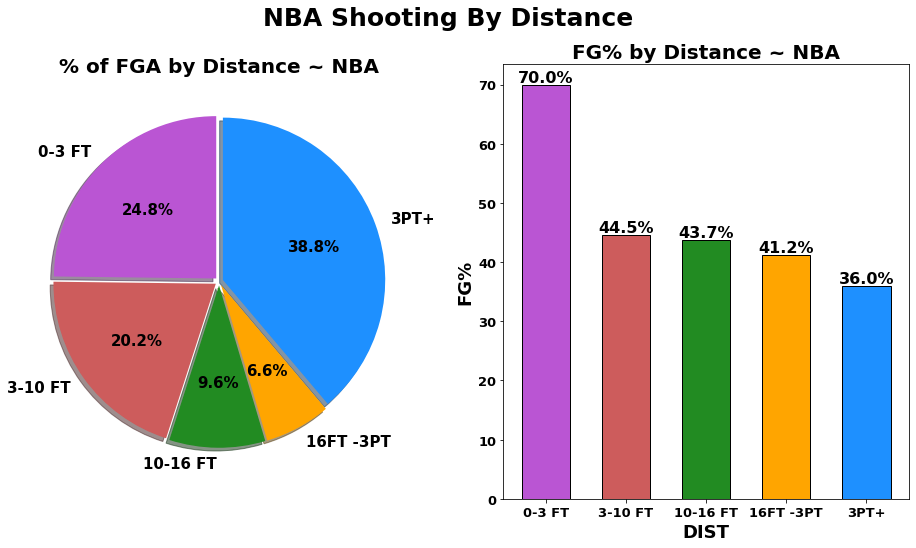

In [8]:
def nba_fg_by_dist():
    plt.rcParams["figure.figsize"] = (10,10)
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']

    att_dist_data = df_team_advshot[['% of FGA by Distance 0-3',
                             '% of FGA by Distance 3-10', 
                             '% of FGA by Distance 10-16', 
                             '% of FGA by Distance 16-3P', 
                             '% of FGA by Distance 3P']].mean()
    
    
    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    ax[0].pie(att_dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title('% of FGA by Distance ~ NBA', fontsize=20, fontweight='bold')
    
    per_dist_data = df_team_advshot[['FG% by Distance 0-3',
                                     'FG% by Distance 3-10',
                                     'FG% by Distance 10-16',
                                     'FG% by Distance 16-3P',
                                     'FG% by Distance 3P']].mean()*100
    
    per_dist = list(per_dist_data.keys())
    per_values = list(per_dist_data)
    
    barWidth = 0.6
    
    ax[1].bar(per_dist, per_values, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title('FG% by Distance ~ NBA', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
        
    plt.suptitle('NBA Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
nba_fg_by_dist()

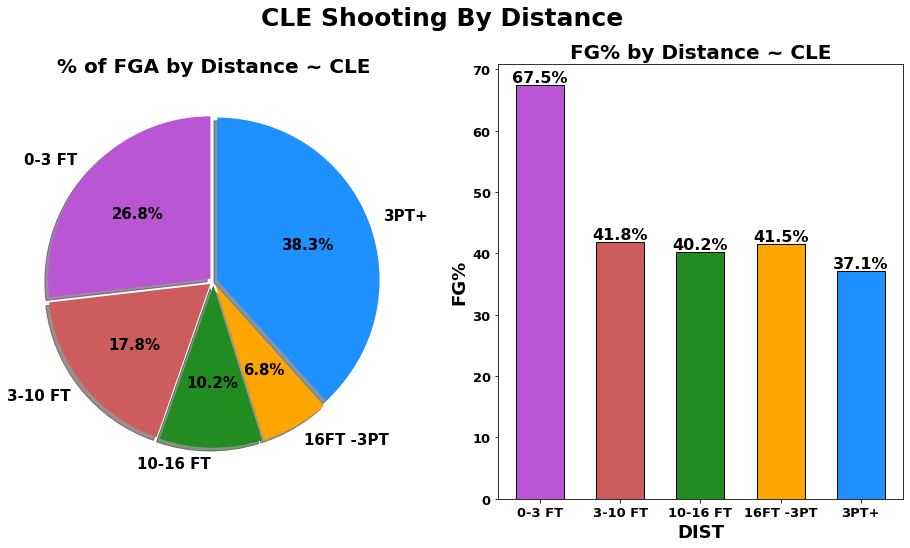

In [9]:
def team_fg_by_dist(abbr):
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']
    barWidth = 0.6
    
    plt.rcParams["figure.figsize"] = (10,10)
    
    dist_data = list(np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3P'].item()]))
    
    dist_data_pct = np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3P'].item()])*100

    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].pie(dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title(f'% of FGA by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    
    ax[1].bar(labels, dist_data_pct, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title(f'FG% by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
    
    plt.suptitle(f'{abbr} Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
team_fg_by_dist('CLE')

## Function to return a teams dataframe

In [10]:
def get_team_df(TEAM_ABBR):
    team_df = df[df['TEAM_ABBREVIATION']==TEAM_ABBR]
    return team_df

## Webscrape NBA records data into a pandas dataframe

In [11]:
columns = ['TEAM_ABBR','TEAM_NAME','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']
data_records=[]
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

for i in df.TEAM_ABBREVIATION.unique(): 
    
    team_abbr = i
    
    team_name = team_abbr_name_dict[i]
    
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count() 
    
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    
    win_per = wins/games
    
    last_10_df = get_team_df(i).head(10)
    
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()
    
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    
    conference = conferences[i]
    
    values = [team_abbr, team_name, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_records.append(a_dictionary)
    
df_records=pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)


df_records

TEAM_ABBR               TEAM_NAME CONFERENCE  GAMES  WINS  LOSES  WIN_PER  \
0        BOS          Boston Celtics       EAST     50    35     15      0.7   
1        DEN          Denver Nuggets       WEST     49    34     15  0.69388   
2        PHI      Philadelphia 76ers       EAST     47    31     16  0.65957   
3        MEM       Memphis Grizzlies       WEST     48    31     17  0.64583   
4        MIL         Milwaukee Bucks       EAST     48    31     17  0.64583   
5        CLE     Cleveland Cavaliers       EAST     50    30     20      0.6   
6        BKN           Brooklyn Nets       EAST     48    29     19  0.60417   
7        LAC    Los Angeles Clippers       WEST     51    27     24  0.52941   
8        SAC        Sacramento Kings       WEST     47    27     20  0.57447   
9        MIA              Miami Heat       EAST     49    27     22  0.55102   
10       NYK         New York Knicks       EAST     50    27     23     0.54   
11       NOP    New Orleans Pelicans       EAST     49    26     23  0.53061   
12       DAL        Dallas Mavericks       WEST     50    26     24     0.52   
13       UTA               Utah Jazz       WEST     51    25     26   0.4902   
14       ATL           Atlanta Hawks       EAST     49    25     24   0.5102   
15       MIN  Minnesota Timberwolves       WEST     50    25     25      0.5   
16       PHX            Phoenix Suns       WEST     50    25     25      0.5   
17       IND          Indiana Pacers       EAST     50    24     26     0.48   
18       GSW   Golden State Warriors       WEST     48    24     24      0.5   
19       OKC   Oklahoma City Thunder       WEST     48    23     25  0.47917   
20       POR  Portland Trail Blazers       WEST     48    23     25  0.47917   
21       LAL      Los Angeles Lakers       WEST     49    23     26  0.46939   
22       CHI           Chicago Bulls       EAST     48    22     26  0.45833   
23       WAS      Washington Wizards       EAST     48    22     26  0.45833   
24       TOR         Toronto Raptors       EAST     49    22     27  0.44898   
25       ORL           Orlando Magic       EAST     48    19     29  0.39583   
26       SAS       San Antonio Spurs       WEST     49    14     35  0.28571   
27       CHA       Charlotte Hornets       EAST     50    14     36     0.28   
28       DET         Detroit Pistons       EAST     50    13     37     0.26   
29       HOU         Houston Rockets       WEST     49    11     38  0.22449   

    LAST_10_WINS  LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  \
0              7              3         18           6         17           9   
1              8              2         22           4         12          11   
2              8              2         18           7         13           9   
3              6              4         20           3         11          14   
4              6              4         19           5         12          12   
5              5              5         20           5         10          15   
6              4              6         13           8         16          11   
7              6              4         14          11         13          13   
8              7              3         16          11         11           9   
9              7              3         16           9         11          13   
10             5              5         12          13         15          10   
11             2              8         17           8          9          15   
12             3              7         17           9          9          15   
13             5              5         16           9          9          17   
14             7              3         13          10         12          14   
15             6              4         16          10          9          15   
16             5              5         18           8          7          17   
17             2              8         16           9          

## Merge W-L onto Team Averages DF

In [12]:
df_team_avg_wl = pd.merge(df_records[['TEAM_ABBR','TEAM_NAME','WINS','LOSES','WIN_PER']],
                          df_team_avg.drop(columns=['TEAM_NAME']),
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')
df_team_avg_wl.head()

TEAM_ABBR           TEAM_NAME  WINS  LOSES  WIN_PER    PTS    AST    BLK  \
0       BOS      Boston Celtics    35     15      0.7 117.62  26.48   5.36   
1       DEN      Denver Nuggets    34     15  0.69388 116.49 28.571 4.4286   
2       PHI  Philadelphia 76ers    31     16  0.65957 114.55 25.085 4.9362   
3       MEM   Memphis Grizzlies    31     17  0.64583  117.1 25.396 5.9792   
4       MIL     Milwaukee Bucks    31     17  0.64583 113.06 24.708 5.1458   

    DREB   FG2A   FG2M  FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  \
0  34.94  46.74  26.34    52.68  41.74  15.46  0.36922    46.38  88.48   41.8   
1 32.714 55.429 31.551   63.102 30.714 12.143  0.39288   36.429 86.143 43.694   
2 31.936 51.255 28.085    56.17 33.426 12.766  0.37843   38.298 84.681 40.851   
3 35.417 60.208  32.25     64.5 32.896 11.479  0.34927   34.438 93.104 43.729   
4 36.542 50.021 26.875    53.75   39.5 14.167  0.35996     42.5 89.521 41.042   

   FG_PCT  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0 0.47378        0.5275        0.4725      0.63016      0.36984       0.44806   
1  0.5088       0.64351       0.35649       0.7202       0.2798        0.5427   
2 0.48357       0.60433       0.39567      0.68493      0.31507       0.49219   
3 0.47015       0.64648       0.35352       0.7378       0.2622       0.55244   
4 0.45977        0.5585        0.4415      0.65285      0.34715       0.47404   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.39302      0.15892   22.4  18.56  0.8333    243   112.12   9.74   
1       0.31224      0.14507 22.837 16.959 0.74445 241.02   112.45 10.184   
2       0.33262      0.17519 24.213 20.085 0.82813 242.66    110.7 8.6383   
3       0.29211      0.15545 25.542 18.167 0.72233 241.04   112.56 13.292   
4       0.37678      0.14917 22.646 16.812 0.74667 242.08    111.5  11.75   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV  
0  18.88         5.5  44.68    6.4 1.6106e+09  13.56  
1 19.367      4.0408 42.898 7.5102 1.6106e+09  14.98  
2 20.681      3.8511 40.574      8 1.6106e+09     14  
3 20.229      4.5417 48.708  8.125 1.6106e+09 14.333  
4 18.271      1.5625 48.292 6.6875 1.6106e+09 15.458

## Master DataFrame for all team averages + records

In [13]:
df_team_master = pd.merge(df_records,
                          df_team_avg.drop(columns=['TEAM_NAME']),
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')

df_team_master = pd.merge(df_team_master,
                          df_team_advshot.drop(columns=['TEAM_NAME']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

df_team_master = pd.merge(df_team_master,
                          df_defense_allowed_team_avg.drop(columns=['TEAM_NAME', 'OPP_PTS']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

df_team_master.head()

TEAM_ABBR           TEAM_NAME CONFERENCE  GAMES  WINS  LOSES  WIN_PER  \
0       BOS      Boston Celtics       EAST     50    35     15      0.7   
1       DEN      Denver Nuggets       WEST     49    34     15  0.69388   
2       PHI  Philadelphia 76ers       EAST     47    31     16  0.65957   
3       MEM   Memphis Grizzlies       WEST     48    31     17  0.64583   
4       MIL     Milwaukee Bucks       EAST     48    31     17  0.64583   

   LAST_10_WINS  LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  \
0             7              3         18           6         17           9   
1             8              2         22           4         12          11   
2             8              2         18           7         13           9   
3             6              4         20           3         11          14   
4             6              4         19           5         12          12   

   WEST_WINS  WEST_LOSES  EAST_WINS  EAST_LOSES    PTS    AST    BLK   DREB  \
0         13           4         22          11 117.62  26.48   5.36  34.94   
1         24           9         10           6 116.49 28.571 4.4286 32.714   
2         12           5         19          11 114.55 25.085 4.9362 31.936   
3         13          13         18           4  117.1 25.396 5.9792 35.417   
4         12           4         19          13 113.06 24.708 5.1458 36.542   

    FG2A   FG2M  FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  \
0  46.74  26.34    52.68  41.74  15.46  0.36922    46.38  88.48   41.8   
1 55.429 31.551   63.102 30.714 12.143  0.39288   36.429 86.143 43.694   
2 51.255 28.085    56.17 33.426 12.766  0.37843   38.298 84.681 40.851   
3 60.208  32.25     64.5 32.896 11.479  0.34927   34.438 93.104 43.729   
4 50.021 26.875    53.75   39.5 14.167  0.35996     42.5 89.521 41.042   

   FG_PCT  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0 0.47378        0.5275        0.4725      0.63016      0.36984       0.44806   
1  0.5088       0.64351       0.35649       0.7202       0.2798        0.5427   
2 0.48357       0.60433       0.39567      0.68493      0.31507       0.49219   
3 0.47015       0.64648       0.35352       0.7378       0.2622       0.55244   
4 0.45977        0.5585        0.4415      0.65285      0.34715       0.47404   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.39302      0.15892   22.4  18.56  0.8333    243   112.12   9.74   
1       0.31224      0.14507 22.837 16.959 0.74445 241.02   112.45 10.184   
2       0.33262      0.17519 24.213 20.085 0.82813 242.66    110.7 8.6383   
3       0.29211      0.15545 25.542 18.167 0.72233 241.04   112.56 13.292   
4       0.37678      0.14917 22.646 16.812 0.74667 242.08    111.5  11.75   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV   G     MP   FG%  Dist  \
0  18.88         5.5  44.68    6.4 1.6106e+09  13.56  50  12150 0.468  14.3   
1 19.367      4.0408 42.898 7.5102 1.6106e+09  14.98  49  11810 0.478  13.8   
2 20.681      3.8511 40.574      8 1.6106e+09     14  47  11405 0.472  14.1   
3 20.229      4.5417 48.708  8.125 1.6106e+09 14.333  48  11570 0.447    14   
4 18.271      1.5625 48.292 6.6875 1.6106e+09 15.458  48  11620 0.455  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.639                     0.206   
1                    0.612                     0.236   
2                    0.617                     0.265   
3                    0.596                     0.258   
4                    0.637                     0.234   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.223                       0.114   
1                      0.231                       0.091   
2                      0.175                       0.092   
3                      0.187                       0.091   
4                      0.184                        0.14   

   % of FGA by Distance 16-

## Correlation Heatmap for Team Average DF

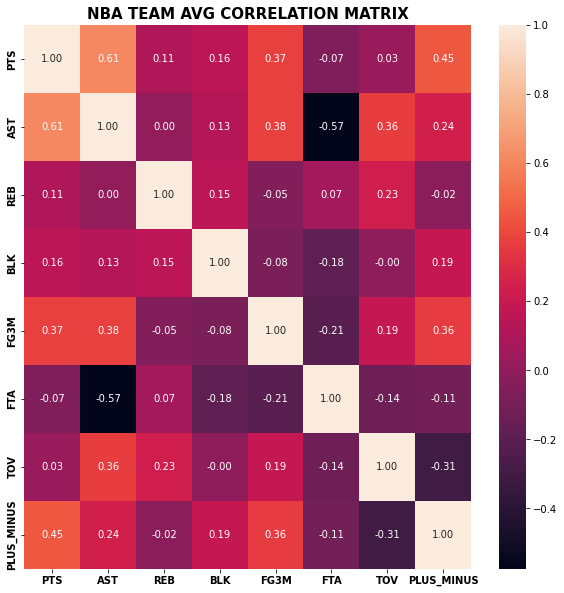

In [14]:
sns.heatmap(df_team_avg[['PTS','AST','REB','BLK','FG3M','FTA','TOV', 'PLUS_MINUS']].corr(), annot=True, fmt='.2f')
plt.title('NBA TEAM AVG CORRELATION MATRIX', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

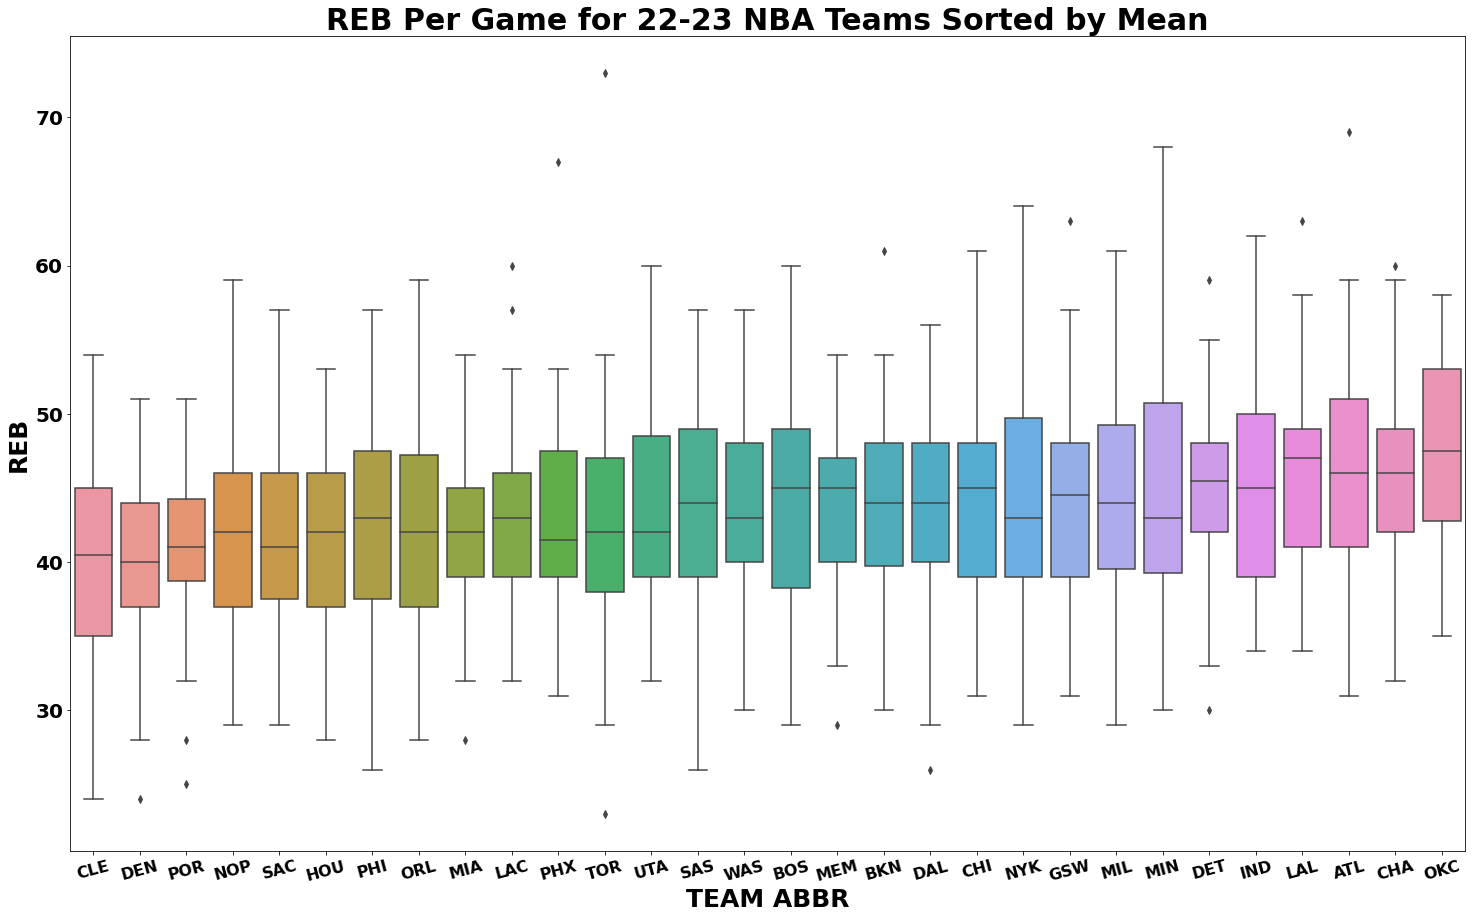

In [15]:
## NBA Stat box plot function
def NBA_stat_boxplots(stat, sort_by='mean', asc=True):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    
    if sort_by == 'mean':
        if asc==True:
            means_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=[True])
        elif asc==False:
            means_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=[False])  
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=means_ppg.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    if sort_by == 'median':
        if asc==True:
            medians_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=[True])
        elif asc==False:
            medians_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=[False])
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=medians_ppg.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Medians', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')
    plt.ylabel(stat, fontsize=25, fontweight='bold')

    plt.show()

NBA_stat_boxplots('REB')

## Plus-Minus Plot Function

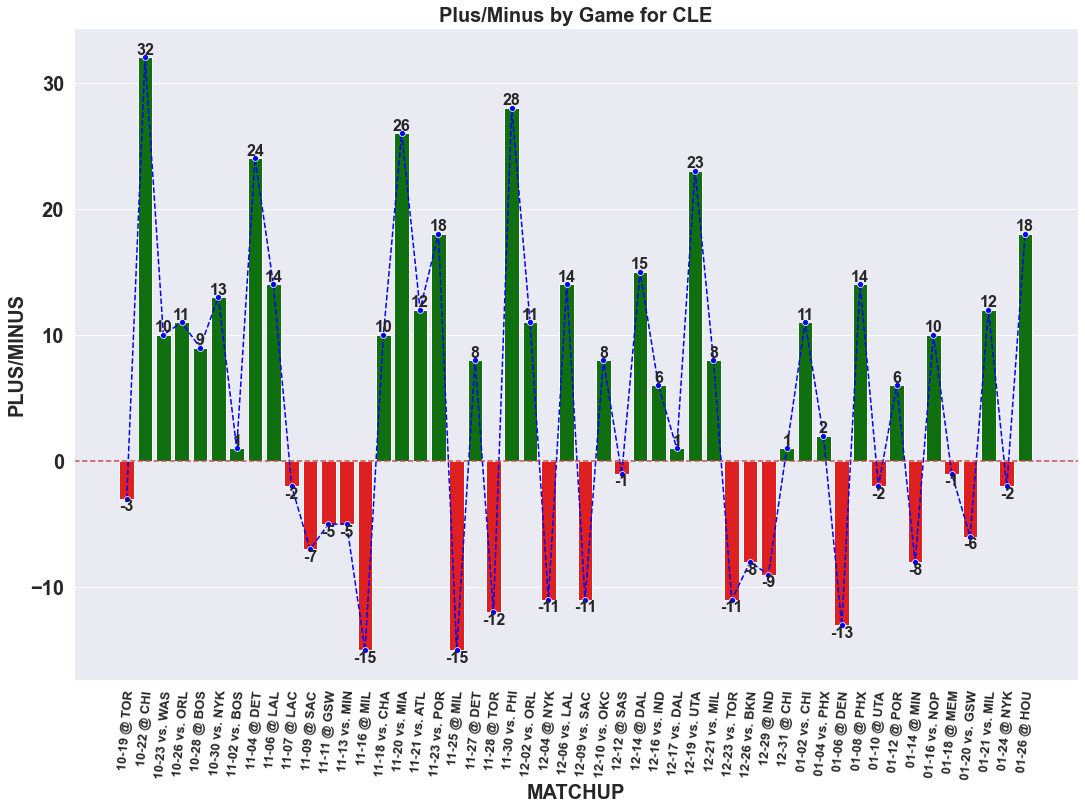

In [16]:
def plus_minus_plot(team_abbr):
    sns.set(rc={'figure.figsize':(18,12)})

    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    values = np.array(df.PLUS_MINUS)
    pal = ['green' if (i > 0) else 'red' for i in values ]
    
    ax1=sns.barplot(data=df, x=df.index, y=values, palette=pal)
    
    ax1.bar_label(ax1.containers[0], fontsize=16, fontweight='bold')
    plt.title(f"Plus/Minus by Game for {team_abbr}", fontsize=20, fontweight='bold')

    ax2=sns.lineplot(data=df, x=df.index, y="PLUS_MINUS",linestyle='--',color='blue', marker='o')
    plt.xticks(rotation=85)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.xticks(df.index,df["DATE_MATCHUP"].values, fontsize=13, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    plt.ylabel('PLUS/MINUS', fontsize=20, fontweight='bold')

    plt.show()
    
plus_minus_plot('CLE')

## Scored vs Allowed Violin Plot Function

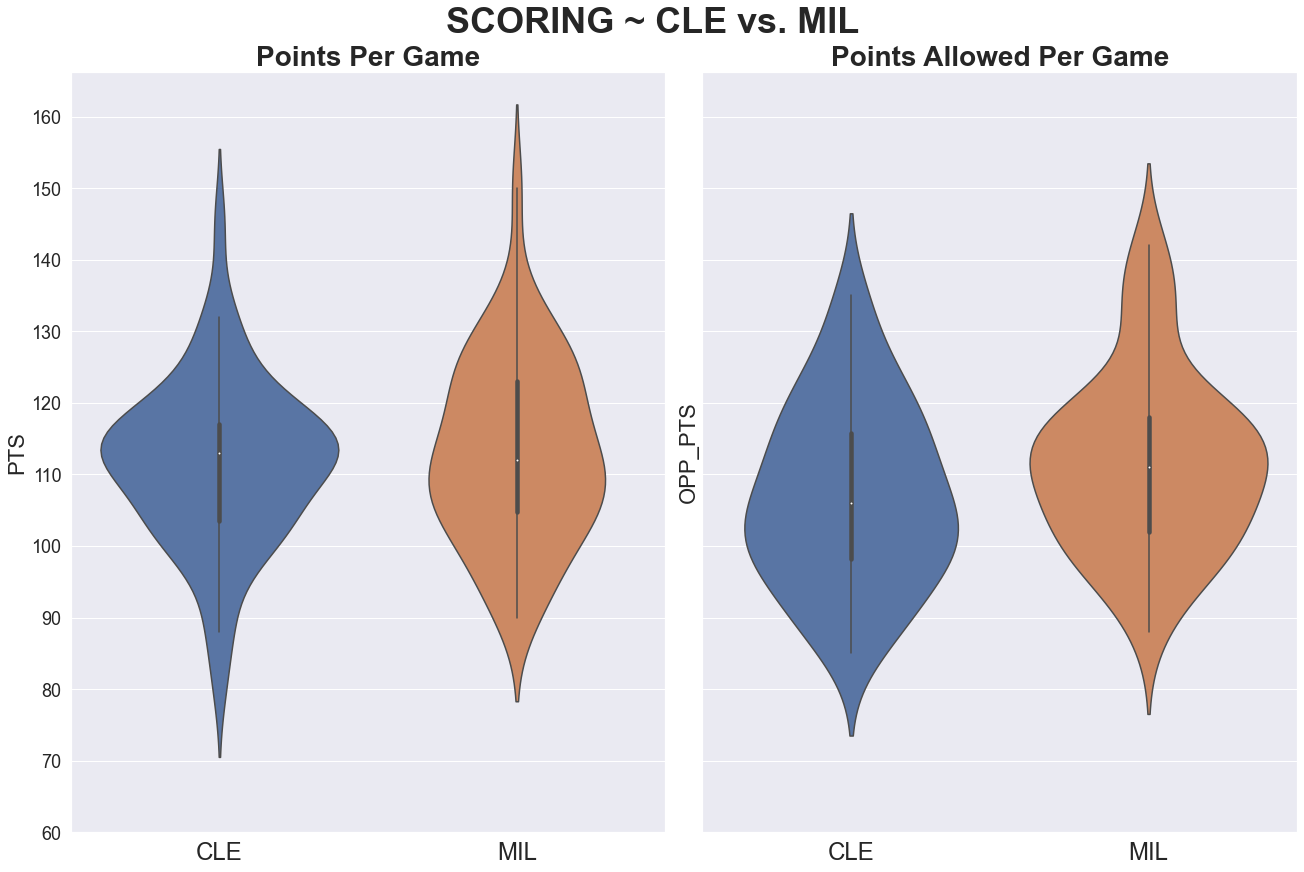

In [17]:
def scored_allowed_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    fig, axs = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
    sns.set(rc={'figure.figsize':(18,12)})

    ax2 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OPP_PTS', ax=axs[1])
    ax2.set_title('Points Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.tick_params(axis='x', which='major', labelsize=24)
    ax2.set_xlabel('')
    ax2.set_ylabel('OPP_PTS', fontsize=22)

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='PTS', ax=axs[0])
    ax1.set_title('Points Per Game', fontsize=28, fontweight='bold')
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.set_ylabel('PTS', fontsize=22)
    ax1.set_xlabel('')

    plt.yticks([60,70,80,90,100,110,120,130,140,150,160])
    fig.suptitle(f'SCORING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=36, fontweight='bold')
    plt.show()
    
scored_allowed_compare("CLE", "MIL")

## Wins vs Losses Pie Charts Function

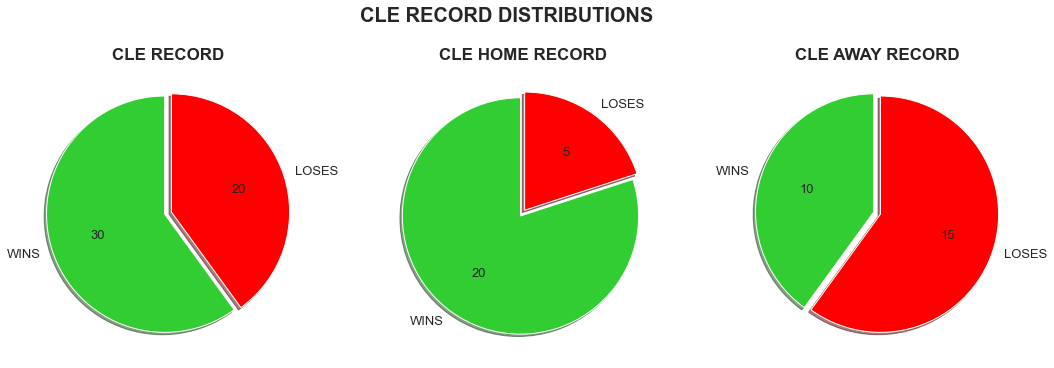

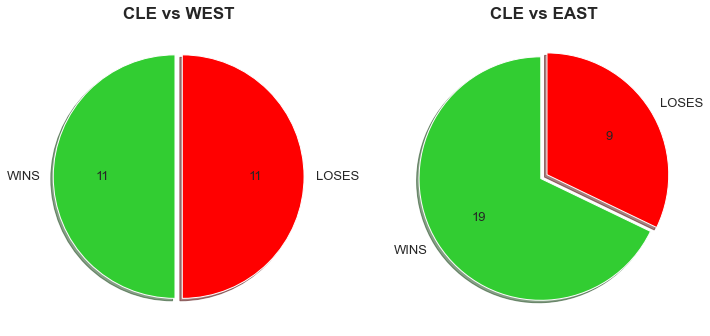

In [18]:
def wl_pies(team_abbr):
    wl_data = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].LOSES.item()])
    wl_data_home = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].HOME_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].HOME_LOSES.item()])
    wl_data_away = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].AWAY_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].AWAY_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl(val):
        a  = np.round(val/100.*wl_data.sum(), 0)
        return int(a)

    def absolute_value_wl_home(val):
        a  = np.round(val/100.*wl_data_home.sum(), 0)
        return int(a)

    def absolute_value_wl_away(val):
        a  = np.round(val/100.*wl_data_away.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


    ax[0].pie(wl_data,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} RECORD", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_home,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_home,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} HOME RECORD", fontsize= 17, fontweight='bold')

    ax[2].pie(wl_data_away,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_away,
            textprops={'fontsize': 13})
    ax[2].set_title(f"{team_abbr} AWAY RECORD", fontsize= 17, fontweight='bold')

    fig.suptitle(f'{team_abbr} RECORD DISTRIBUTIONS', fontsize=20, fontweight="bold")

    wl_pies_EW(team_abbr)

    plt.show()


def wl_pies_EW(team_abbr):
    wl_data_east = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].EAST_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].EAST_LOSES.item()])
    wl_data_west = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].WEST_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].WEST_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl_east(val):
        a  = np.round(val/100.*wl_data_east.sum(), 0)
        return int(a)

    def absolute_value_wl_west(val):
        a  = np.round(val/100.*wl_data_west.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


    ax[0].pie(wl_data_west,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_west,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} vs WEST", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_east,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_east,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} vs EAST", fontsize= 17, fontweight='bold')

    plt.show()
    
wl_pies("CLE")

## Multi Team Violin Plot Comparsion Function

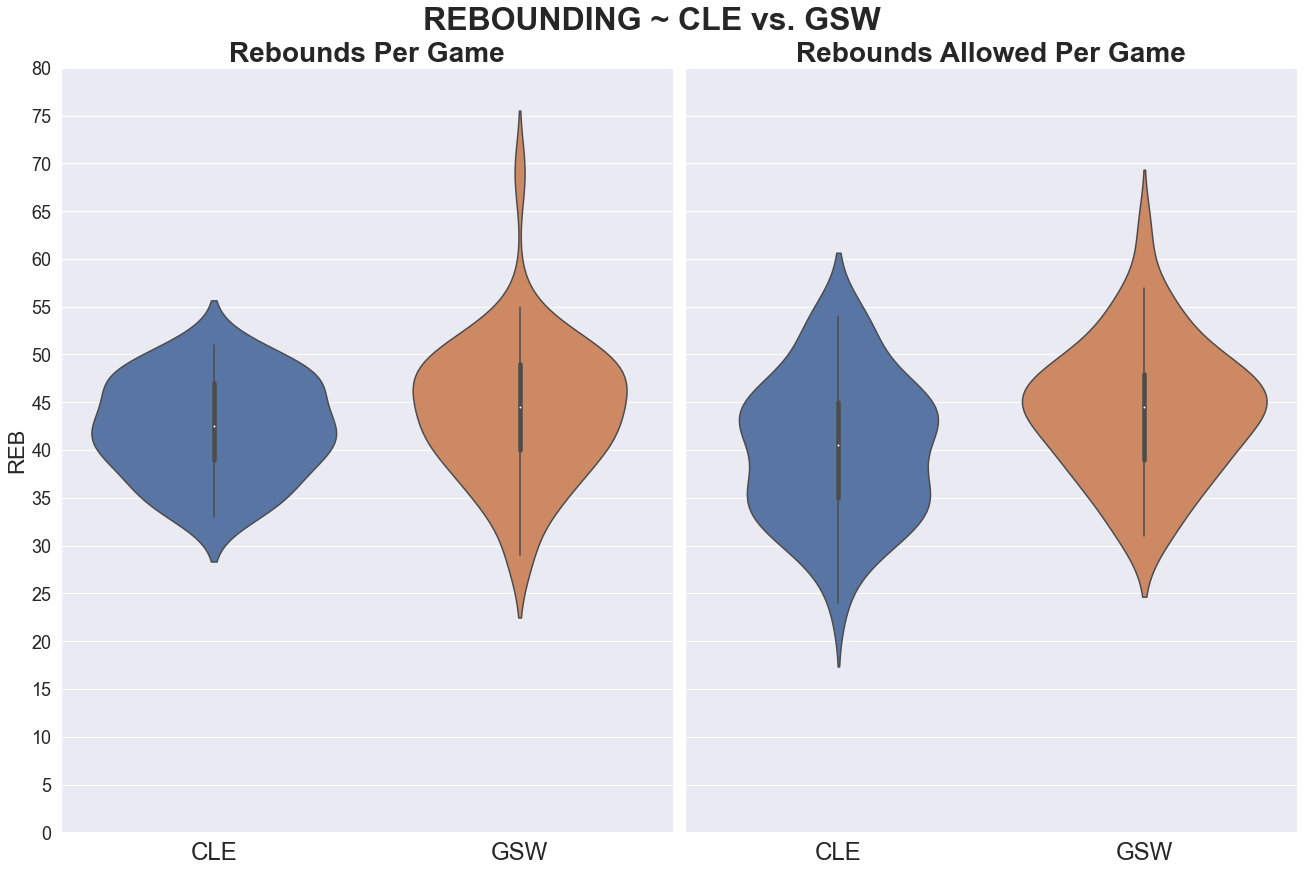

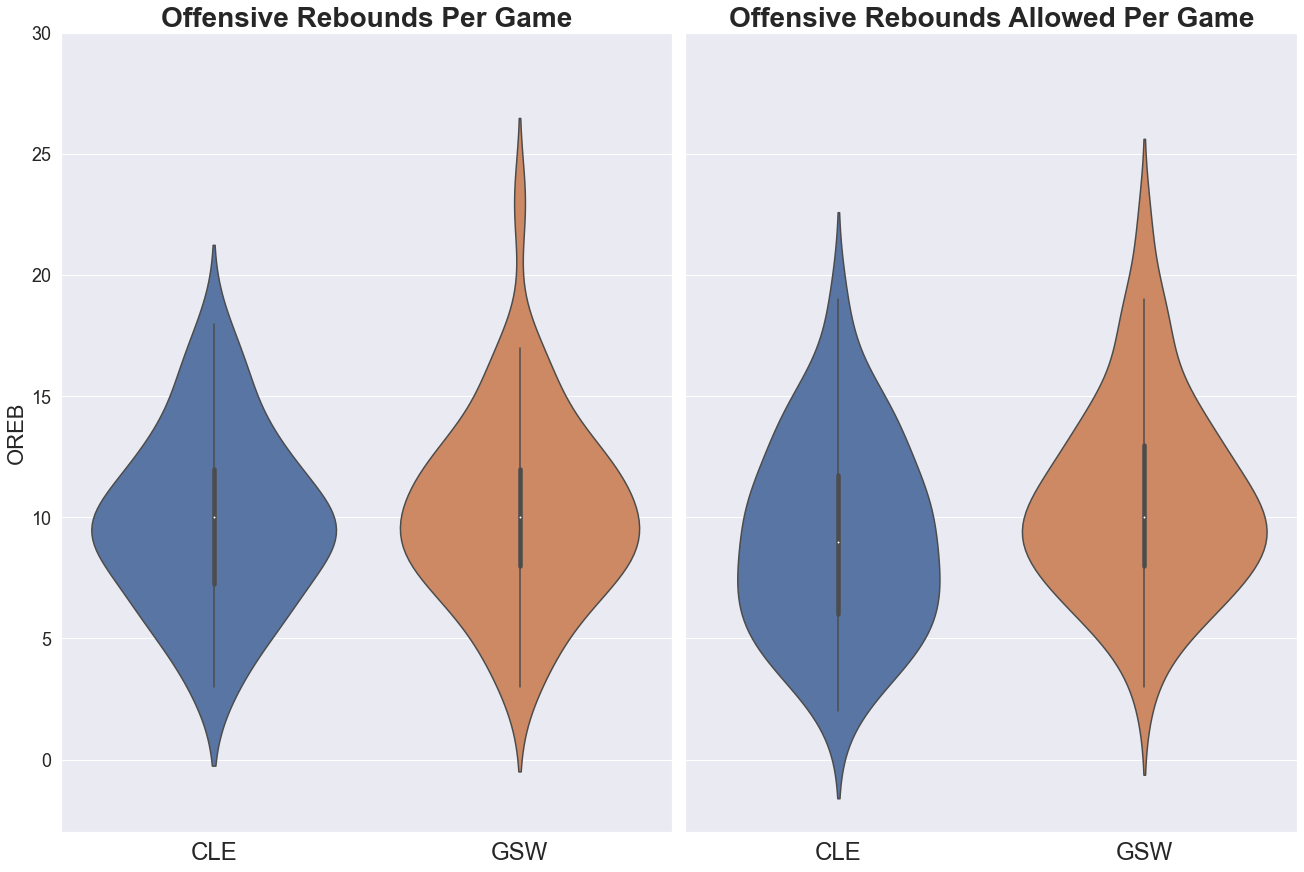

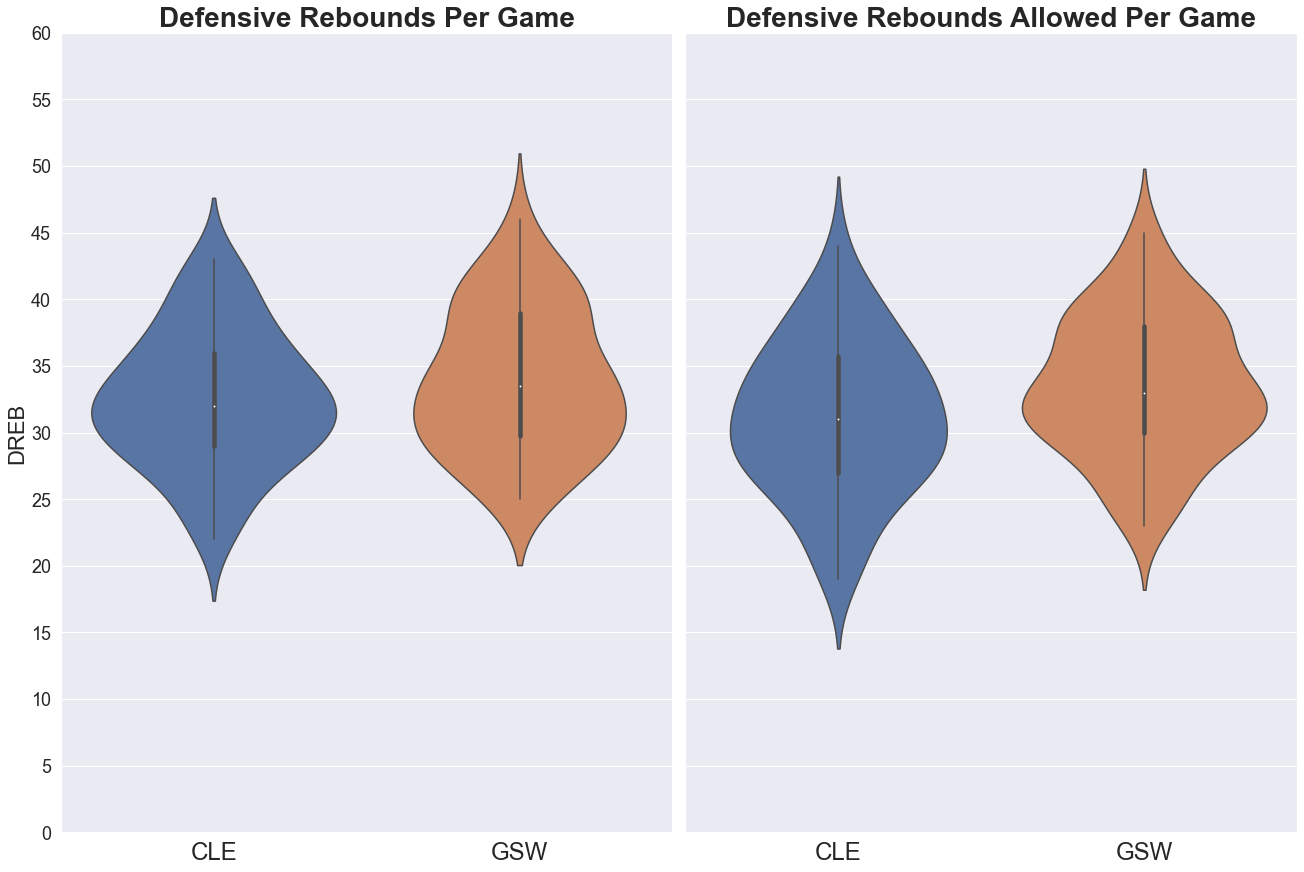

In [19]:
def rebounds_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='REB', ax=axs[0])
    ax1.set_title(f'Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('REB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='REB', ax=axs[1])
    ax2.set_title(f'Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40, 45, 50, 55, 60, 65, 70, 75, 80])

    fig.suptitle(f'REBOUNDING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=32, fontweight='extra bold')
    plt.show()

    print()
    oreb_compare(team_a_abbr,team_b_abbr)
    print()
    dreb_compare(team_a_abbr,team_b_abbr)
    print()

    # ADD REBOUNDING DIFFERENTIALS

def oreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OREB', ax=axs[0])
    ax1.set_title(f'Offensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('OREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='OREB', ax=axs[1])
    ax2.set_title(f'Offensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30])

    plt.show()

def dreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='DREB', ax=axs[0])
    ax1.set_title(f'Defensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('DREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='DREB', ax=axs[1])
    ax2.set_title(f'Defensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])

    plt.show()
    
rebounds_compare('CLE','GSW')

## Team Scoring Line Plot Function

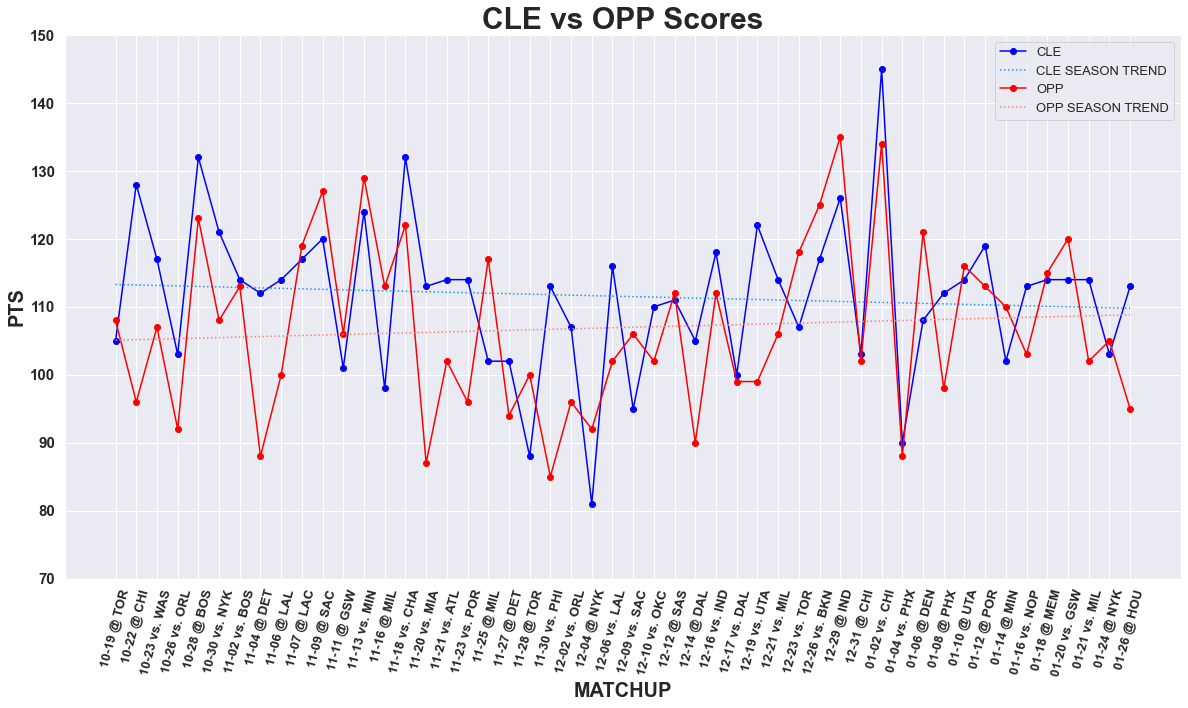

In [20]:
def line_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    team_score = plt.plot(df.index, df['PTS'], marker='o', label=team_abbr, color='blue')
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=1.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    opp_score = plt.plot(df.index, df['OPP_PTS'], marker='o', label='OPP', color='red')
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=1.5, color='salmon', label='OPP SEASON TREND')
    
    plt.legend(loc='best', fontsize=13)
    plt.title(f'{team_abbr} vs OPP Scores',fontsize=30, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)
    plt.xlabel('MATCHUP',fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
line_plot_scores("CLE")

## Trend Plot Scores Function

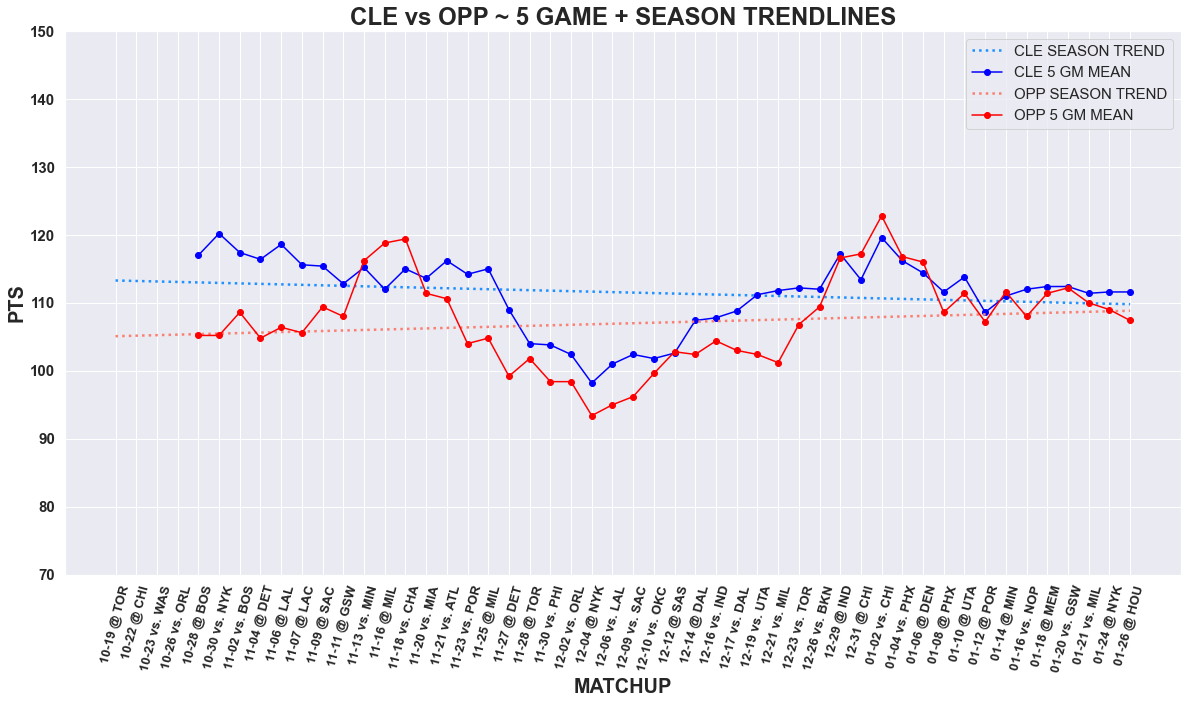

In [21]:
def trend_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=2.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    rolling_mean = df.PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="BLUE", alpha=1,marker='o', label=f"{team_abbr} 5 GM MEAN")
    
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=2.5, color='salmon', label='OPP SEASON TREND')
    
    rolling_mean = df.OPP_PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="RED", alpha=1,marker='o', label=f"OPP 5 GM MEAN")
    
    plt.legend(loc='best', fontsize=15)
    plt.title(f'{team_abbr} vs OPP ~ 5 GAME + SEASON TRENDLINES',fontsize=24, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15,  fontweight='bold')
    plt.ylim(70, 150)
    
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
trend_plot_scores("CLE")

## Shooting Distribution Pie Chart Function

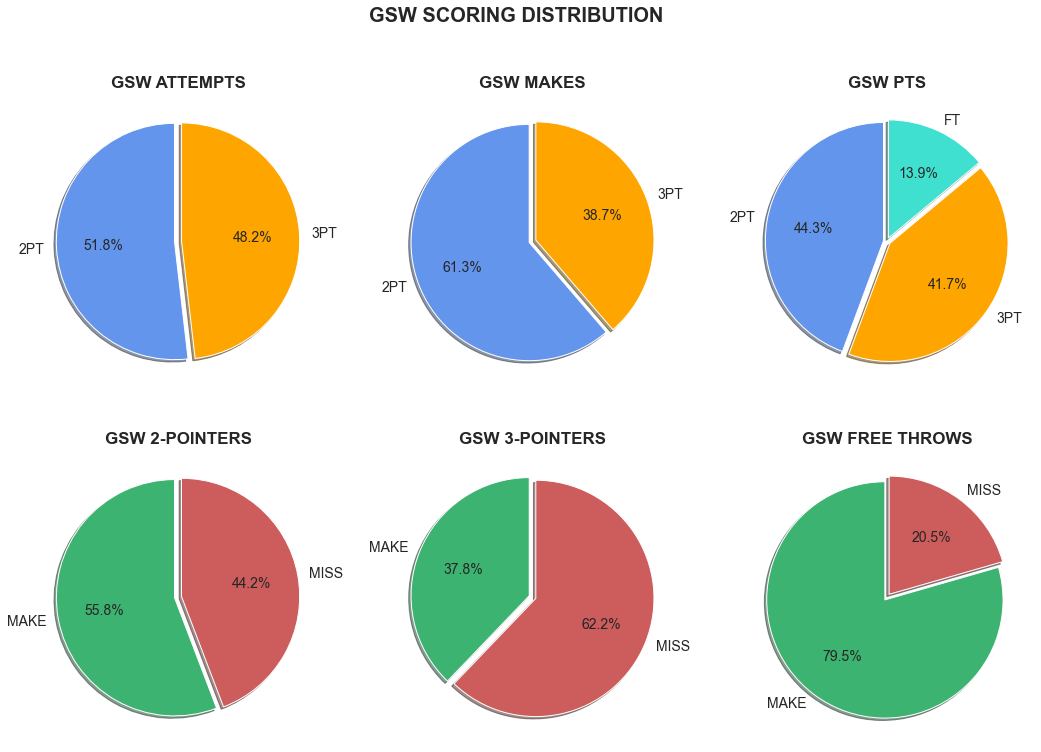

In [22]:
def shot_pies(team_abbr):
    
    df_team = df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr]
    
    data_att = [df_team.FRAC_ATT_2PT.item(), df_team.FRAC_ATT_3PT.item()]
    data_mk = [df_team.FRAC_MK_2PT.item(), df_team.FRAC_MK_3PT.item()]
    data_pts = [df_team.FRAC_PTS_2PT.item(), df_team.FRAC_PTS_3PT.item(), df_team.FRAC_PTS_FT.item()]
    
    data_2pt = [df_team.FG2M.item(), (df_team.FG2A.item() - df_team.FG2M.item())]
    data_3pt = [df_team.FG3M.item(), (df_team.FG3A.item() - df_team.FG3M.item())]
    data_ft = [df_team.FTM.item(), (df_team.FTA.item() - df_team.FTM.item())]
    
    labels1 = ['2PT', '3PT']
    labels2 = ['2PT', '3PT', 'FT']
    labels3 = ['MAKE', 'MISS']
    explode1 = [0.03, 0.03]
    explode2 = [0.03,0.03,0.03]
    colors0 = ['cornflowerblue', 'orange']
    colors1= ['cornflowerblue', 'orange', 'turquoise']
    colors2 = ['mediumseagreen','indianred']
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    
    ax[0,0].pie(data_att,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,0].set_title(f'{team_abbr} ATTEMPTS', fontsize=17, fontweight='bold')
    
    ax[0,1].pie(data_mk,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,1].set_title(f'{team_abbr} MAKES', fontsize=17, fontweight='bold')
    
    ax[0,2].pie(data_pts,
              labels=labels2,
              explode=explode2,
              shadow=True,
              colors=colors1,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,2].set_title(f'{team_abbr} PTS', fontsize=17, fontweight='bold')
    
    ax[1,0].pie(data_2pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,0].set_title(f'{team_abbr} 2-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,1].pie(data_3pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,1].set_title(f'{team_abbr} 3-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,2].pie(data_ft,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,2].set_title(f'{team_abbr} FREE THROWS', fontsize=17, fontweight='bold')
    
    fig.suptitle(f'{team_abbr} SCORING DISTRIBUTION', fontsize=20, fontweight="bold")
    plt.show()
    
shot_pies('GSW')

# Regrssion Analysis Plots ~ League Trends

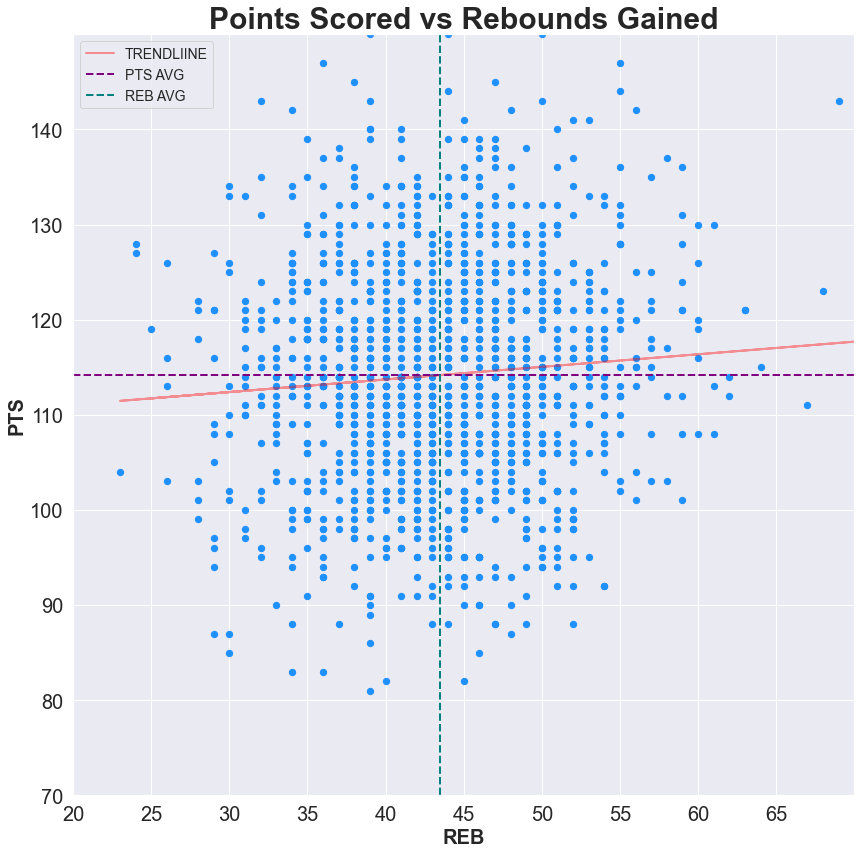

Season Trend Line Equation
y=0.132451x+(108.413402)

R-squared: 0.005859724537647382

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.3251
Date:                Fri, 27 Jan 2023   Prob (F-statistic):              0.573
Time:                        13:28:42   Log-Likelihood:                -73.179
No. Observations:                  31   AIC:                             150.4
Df Residuals:                      29   BIC:                             153.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [23]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.REB
y=df.PTS

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

plt.scatter(x,y, color='dodgerblue', s=40)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.REB.mean(), label="REB AVG", linestyle='dashed', color='teal', linewidth=2)

plt.xlim(20,70)
plt.xticks(list(range(20,70,5)), fontsize=20)
plt.xlabel('REB', fontsize=20, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20)
plt.ylabel('PTS', fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Rebounds Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' +color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ REB', data=df_team_avg).fit()
print()
print(lm.summary())

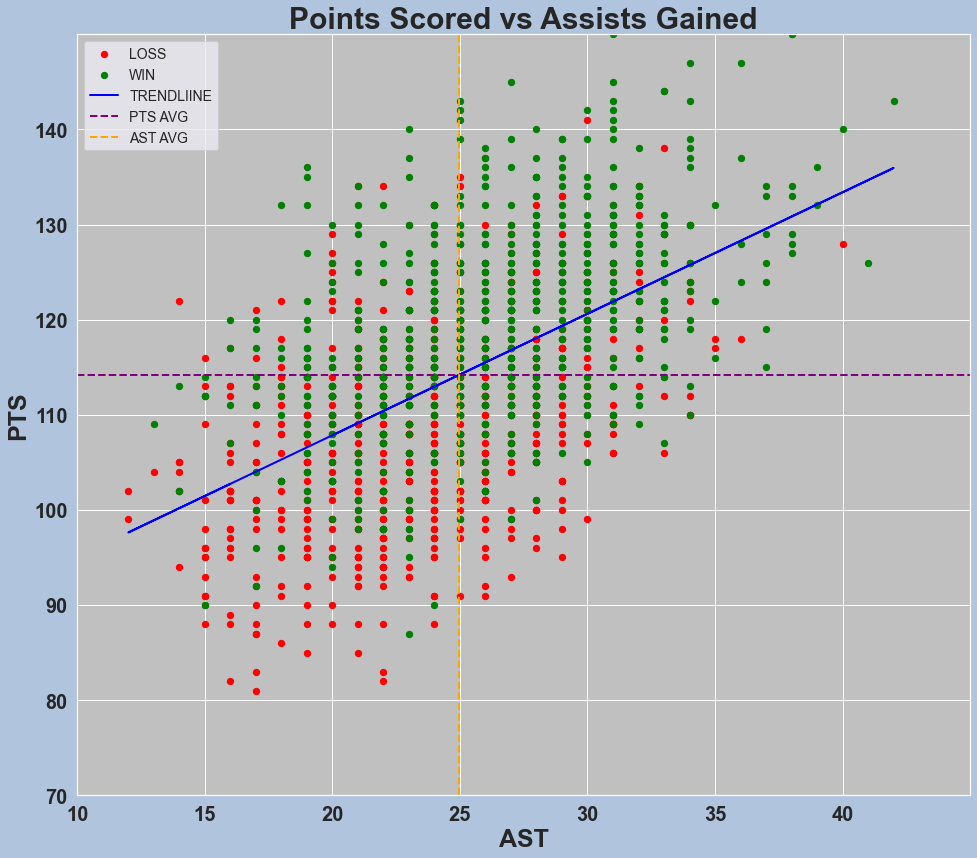

Season Trend Line Equation
y=1.277050x+(82.307660)

R-squared: 0.2849590917789683

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.08
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           0.000278
Time:                        13:28:42   Log-Likelihood:                -66.173
No. Observations:                  31   AIC:                             136.3
Df Residuals:                      29   BIC:                             139.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
ax.set_facecolor('silver')
fig.set_facecolor('lightsteelblue')
fig.set_edgecolor('black')

x=df.AST
y=df.PTS

x_L=df[df.WL=='L'].AST
y_L=df[df.WL=='L'].PTS

x_W=df[df.WL=='W'].AST
y_W=df[df.WL=='W'].PTS

plt.scatter(x_L,y_L, color='red', label='LOSS', s=40)
plt.scatter(x_W,y_W, color='green', label='WIN', s=40)

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=1, color='blue', linewidth=2)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.AST.mean(), label="AST AVG", linestyle='dashed', color='orange', linewidth=2)

plt.xlim(10,45)
plt.xticks(list(range(10,45,5)), fontsize=20, fontweight='bold')
plt.xlabel('AST', fontsize=25, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20, fontweight='bold')
plt.ylabel('PTS', fontsize=25, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Assists Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ AST', data=df_team_avg).fit()
print()
print(lm.summary())

## Team Average Reression (statx vs staty) Plot and Analysis Function

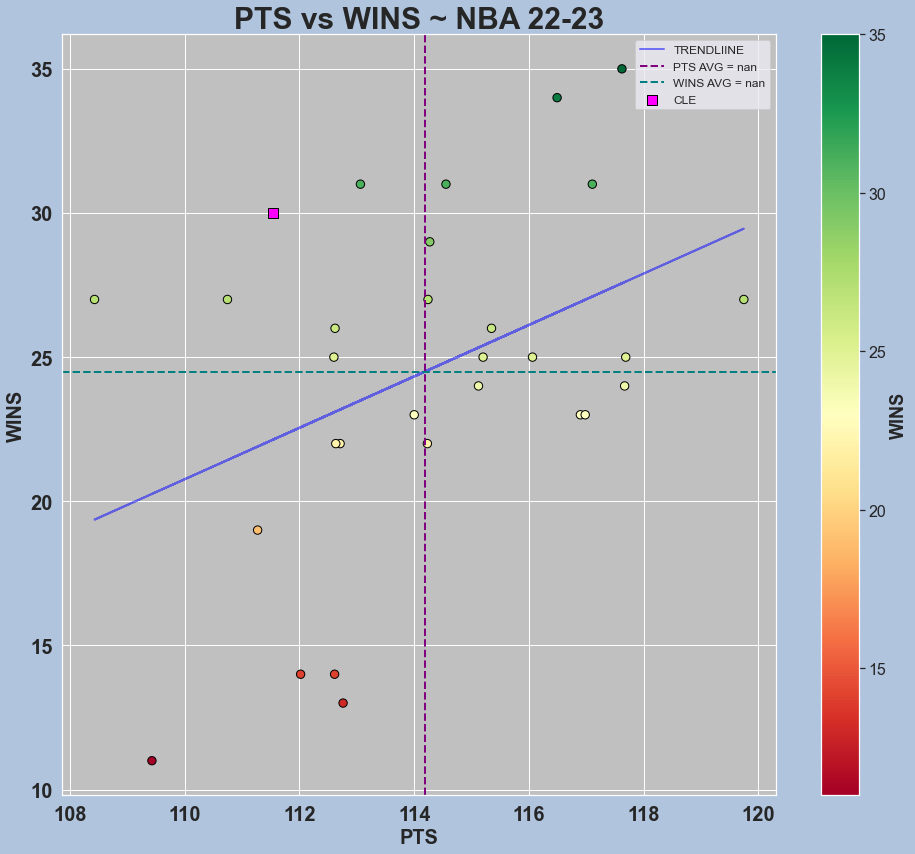


Season Trend Line Equation: y = 0.892015x + (-77.357333)

R-squared: 0.16409257659750254


                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.497
Date:                Fri, 27 Jan 2023   Prob (F-statistic):             0.0264
Time:                        13:28:42   Log-Likelihood:                -92.470
No. Observations:                  30   AIC:                             188.9
Df Residuals:                      28   BIC:                             191.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [25]:
# Add ability to specify other dataframes

def regression_analysis_team_avg(statx, staty, team_abbr=''):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    
    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')
    
    df_new = df_team_master.copy()

    x=df_new[statx]
    y=df_new[staty]

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)

    plt.scatter(x,y, c=y, cmap='RdYlGn',edgecolor='black', s=70)

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][statx].mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][staty].mean(),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=20, fontweight='bold')
    plt.ylabel(staty, fontsize=20, fontweight='bold')

    plt.title(f'{statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    if team_abbr != '':
        try:
            x_team = df_new[df_new.TEAM_ABBR == team_abbr][statx]
            y_team = df_new[df_new.TEAM_ABBR == team_abbr][staty]
            plt.scatter(x_team,y_team, color='magenta', edgecolor='black', marker='s', s=100, label=team_abbr)
        except: pass
    
    plt.legend(loc='best', fontsize=12)
    
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()

    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_new).fit()
    print()
    print(lm.summary())

regression_analysis_team_avg('PTS', 'WINS', team_abbr='CLE')

## Multi Linear Regression Model

In [34]:
#x - as list
#y - as string

def multi_lin_reg(df,x,y):
    x = df[x]
    y = df[y]

    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    print(model.summary())
    
multi_lin_reg(df_team_master, ['PTS','FG3M','REB','AST','TOV'], 'WINS')

                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     2.971
Date:                Fri, 27 Jan 2023   Prob (F-statistic):             0.0316
Time:                        13:40:47   Log-Likelihood:                -87.933
No. Observations:                  30   AIC:                             187.9
Df Residuals:                      24   BIC:                             196.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.2908     47.987     -0.444      0.6

## 3D Scatter Plot Function

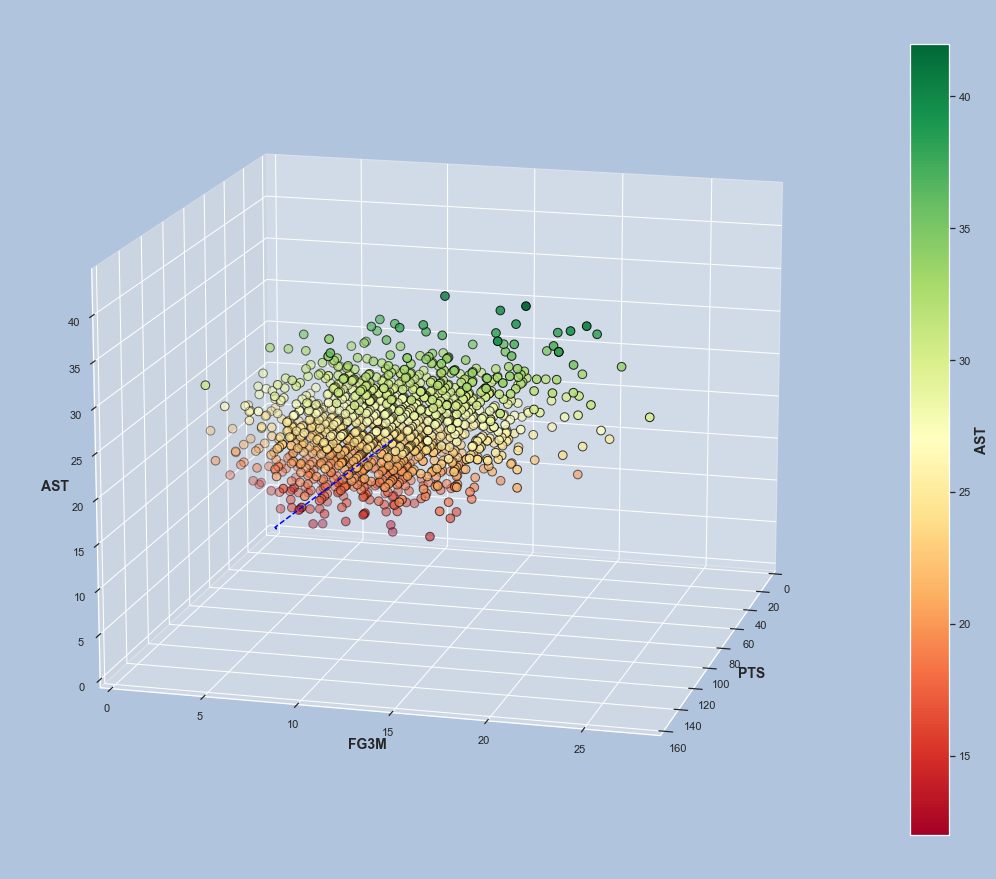

In [26]:
def scatter_3d(df,x,y,z, xview=15, yview=15,zview=0, sv_anim=False):
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()
    
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(projection='3d')
    
    ax.set_facecolor('lightsteelblue')
    fig.set_facecolor('lightsteelblue')
    
    ax.set_xlabel(x, fontweight='bold', fontsize=14)
    ax.set_ylabel(y, fontweight='bold', fontsize=14)
    ax.set_zlabel(z, fontweight='bold', fontsize=14)
    
    xdata=df[x].fillna(0)
    ydata=df[y].fillna(0)
    zdata=df[z].fillna(0)
    
    sc = ax.scatter(xdata,ydata,zdata,c=zdata, cmap=initial_cmap, edgecolor='black', s=75)

    cbar = fig.colorbar(sc, ax=ax, fraction=0.042, pad=0.04)
    cbar.set_label(z, fontsize=14, fontweight='bold')
    
    t = np.arange(df.shape[0])

    fitx = np.polyfit(t, xdata, 15)
    fity = np.polyfit(t, ydata, 15)
    fitz = np.polyfit(t, zdata, 15)

    ax.plot(fitx,fity,fitz, color='blue', linestyle='dashed')
    
    plt.xlim(0,None)
    plt.ylim(0,None)
    ax.set_zlim(0,None)
    
    plt.grid()
    plt.tight_layout()
    
    ax.view_init(xview,yview,zview)
        
    if sv_anim:
        
        def init():
            ax.view_init(elev=15., azim=0)
            return [sc]
        
        def animate(i):
            ax.view_init(elev=15., azim=i)
            return [sc]
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
        
        plt.show()
        
        try: os.mkdir('C:\\Users\\Peter\\NFL_3D_Scatter_Anims')
        except: pass
        
        try: ani.save(f'C:\\Users\\Peter\\NFL_3D_Scatter_Anims\\{x}_{y}_{z}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        except: pass
        
    
    else:
        plt.show()
        
scatter_3d(df,'PTS','FG3M','AST', sv_anim=False)

# Go to save location to view animation
# TODO: Display animation, currently having issues, but saved video is available

## Function to return DF with R2 for a specified stat

In [27]:
def r2_comparison_from_y(df, staty):
    
    pd.set_option('display.max_rows', None)
    
    df_new = df.copy()
    
    try: df_new = df_new.drop(columns=['TEAM_NAME'])
    except: pass
    try: df_new = df_new.drop(columns=['TEAM_ABBR'])
    except: pass
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    y=df_new[staty]
    y=y.fillna(y.mean())
    
    for i in df_new.columns:
        x=df_new[i]
        try: x=x.fillna(x.mean())
        except: x=x.fillna(0)
        if is_numeric_dtype(df_new[i]):
            model = LinearRegression()
            model = model.fit(x.values.reshape(-1, 1), y)
            r2= model.score(x.values.reshape(-1, 1), y)
            df_temp = pd.DataFrame([[i, staty, r2]], columns=['x','y','r2'])
            df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparison_from_y(df_team_master, 'WINS')

x     y         r2
0                          WINS  WINS          1
1                       WIN_PER  WINS    0.99035
2                         LOSES  WINS    0.96842
3                    PLUS_MINUS  WINS    0.88601
4                OPP_PLUS_MINUS  WINS    0.88601
5                    HOME_LOSES  WINS    0.78452
6                     HOME_WINS  WINS      0.759
7                    AWAY_LOSES  WINS    0.68146
8                     AWAY_WINS  WINS    0.59277
9                       OPP_PTS  WINS    0.48905
10                 LAST_10_WINS  WINS    0.45713
11                LAST_10_LOSES  WINS    0.45713
12                   Dunks %FGA  WINS    0.42281
13                    EAST_WINS  WINS    0.42112
14                   WEST_LOSES  WINS    0.39965
15                    Dunks Md.  WINS    0.39576
16                      OPP_BLK  WINS    0.39521
17                   EAST_LOSES  WINS    0.37352
18                      FG3_PCT  WINS    0.35073
19                    WEST_WINS  WINS    0.33058
20                   OPP_FG_PCT  WINS    0.30641
21           FG% by Distance 2P  WINS    0.30634
22                          FG%  WINS    0.30364
23                      OPP_AST  WINS    0.29296
24                     OPP_FG3M  WINS    0.27645
25                  OPP_FG3_PTS  WINS    0.27645
26                      OPP_FGM  WINS    0.26493
27   % of FGA by Distance 10-16  WINS     0.2282
28                       FG_PCT  WINS    0.20903
29                         FG3M  WINS    0.17725
30                      FG3_PTS  WINS    0.17725
31                    OPP_MONTH  WINS    0.17359
32           FG% by Distance 3P  WINS    0.17209
33         FG% by Distance 3-10  WINS    0.16432
34                  OPP_OPP_PTS  WINS    0.16409
35                          PTS  WINS    0.16409
36                      TEAM_ID  WINS    0.15839
37                  OPP_FG3_PCT  WINS    0.14807
38                 FRAC_PTS_3PT  WINS    0.14492
39                  FRAC_MK_2PT  WINS    0.12488
40                  FRAC_MK_3PT  WINS    0.12488
41                         FG2A  WINS    0.11949
42   % of FGA by Distance 16-3P  WINS    0.11858
43                      OPP_FTM  WINS    0.11847
44                           PF  WINS    0.11828
45                     OPP_FG3A  WINS    0.10276
46                         OREB  WINS   0.099617
47                          AST  WINS   0.095713
48                 FRAC_PTS_2PT  WINS   0.092968
49                      OPP_FTA  WINS   0.092113
50                 FRAC_ATT_2PT  WINS   0.090394
51                 FRAC_ATT_3PT  WINS   0.090394
52                         DREB  WINS   0.087117
53                      OPP_STL  WINS   0.084247
54                   Corner 3P%  WINS   0.067971
55      % of FGA by Distance 3P  WINS   0.067114
56      % of FGA by Distance 2P  WINS   0.067114
57                      OPP_REB  WINS   0.066042
58                  FRAC_PTS_FT  WINS   0.064783
59             OPP_FRAC_ATT_3PT  WINS   0.064673
60             OPP_FRAC_ATT_2PT  WINS   0.064673
61                          FGA  WINS    0.06001
62                          TOV  WINS    0.05796
63                         FG3A  WINS   0.056947
64        FG% by Distance 10-16  WINS   0.052425
65                   Layups Md.  WINS   0.052034
66                       FT_PCT  WINS   0.051003
67                          FGM  WINS   0.049894
68                          FTA  WINS   0.049423
69             OPP_FRAC_PTS_2PT  WINS   0.047476
70                     OPP_DREB  WINS    0.04576
71                   OPP_FT_PCT  WINS   0.045702
72                     OPP_FG2M  WINS   0.043761
73                  OPP_FG2_PTS  WINS   0.043761
74              OPP_FRAC_MK_2PT  WINS   0.043231
75              OPP_FRAC_MK_3PT  WINS   0.043231
76        FG% by Distance 16-3P  WINS   0.042094
77          FG% by Distance 0-3  WINS   0.040464
78             % of FG Ast'd 2P  WINS    0.04027
79                  Corner %3PA  WINS   0.039931
80                     OPP_OREB  WINS   0.039898
81          

## Functions to Visually Compare Statistical Distributions

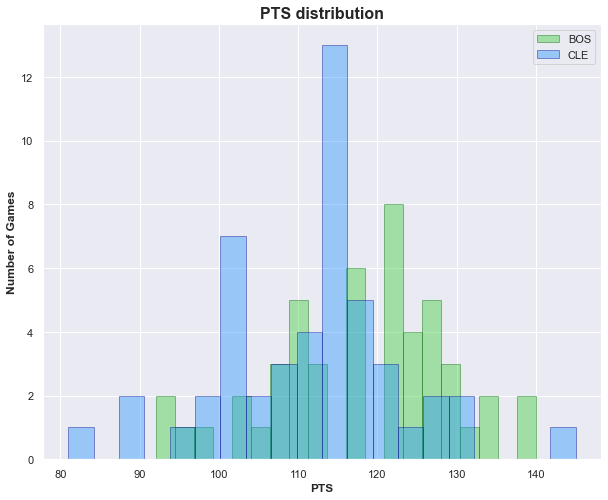

In [53]:
def team_stat_hist_compare(stat,bins,abbr1,abbr2):
    plt.figure(figsize=(10,8))
    plt.xlabel(stat, fontweight='bold')
    plt.ylabel('Number of Games', fontweight='bold')
    df[df.TEAM_ABBREVIATION==abbr1][stat].hist(bins=bins, alpha=.4, color='limegreen', edgecolor='darkgreen', label=abbr1)
    df[df.TEAM_ABBREVIATION==abbr2][stat].hist(bins=bins, alpha=.4, color='dodgerblue',edgecolor='darkblue', label=abbr2)
    plt.legend(loc='best')
    plt.title(f'{stat} distribution', fontsize=16, fontweight='bold')
    plt.show()
    
    
team_stat_hist_compare('PTS',20,'BOS','CLE')

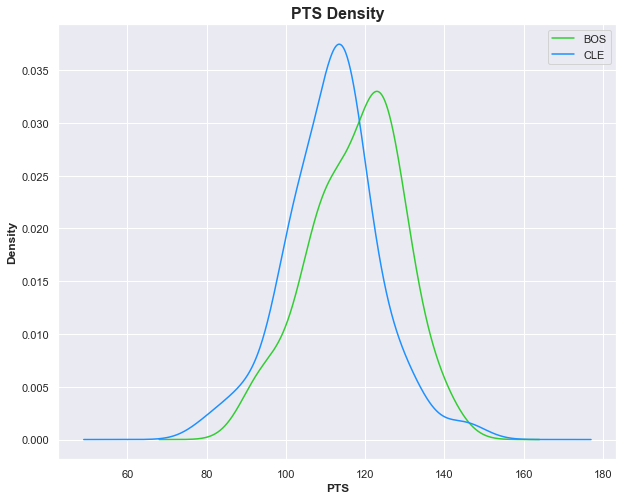

In [56]:
def team_stat_kde_compare(stat,abbr1,abbr2):
    plt.figure(figsize=(10,8))
    plt.xlabel(stat, fontweight='bold')
    plt.ylabel('Density', fontweight='bold')

    df[df.TEAM_ABBREVIATION==abbr1][stat].plot.kde(color='limegreen', label=abbr1)
    df[df.TEAM_ABBREVIATION==abbr2][stat].plot.kde(color='dodgerblue', label=abbr2)
    
    plt.legend(loc='best')
    plt.title(f'{stat} Density', fontsize=16, fontweight='bold')
    plt.show()
    
team_stat_kde_compare('PTS','BOS','CLE')

## Gaussian Game Simulation Functions

In [163]:
def gauss_game_sim(team1abbr, team2abbr):
    
    team1Score = int(round(rnd.gauss(df[df.TEAM_ABBREVIATION==team1abbr].PTS.mean(),df[df.TEAM_ABBREVIATION==team1abbr].PTS.std())\
                 +rnd.gauss(df[df.TEAM_ABBREVIATION==team2abbr].OPP_PTS.mean(),df[df.TEAM_ABBREVIATION==team2abbr].OPP_PTS.std()))/2)
    
    team2Score = int(round(rnd.gauss(df[df.TEAM_ABBREVIATION==team2abbr].PTS.mean(),df[df.TEAM_ABBREVIATION==team2abbr].PTS.std())\
                 +rnd.gauss(df[df.TEAM_ABBREVIATION==team1abbr].OPP_PTS.mean(),df[df.TEAM_ABBREVIATION==team1abbr].OPP_PTS.std()))/2)
    
    
    if team1Score > team2Score:
        return 1
    elif team1Score < team2Score:
        return -1
    else: return 0
    
gauss_game_sim('CLE','BOS')

1

In [206]:
# n ~ number of games to simulate

def game_simulations(n, team1abbr, team2abbr):
    gameResults = []
    team1Wins = 0
    team2Wins = 0
    Ties = 0
    for i in range(n):
        gm = gauss_game_sim(team1abbr, team2abbr)
        gameResults.append(gm)
        if gm == 1:
            team1Wins += 1
        elif gm == -1:
            team2Wins += 1
        else: Ties += 1
            
    team1WinPer = team1Wins/(n)
    team2WinPer = team2Wins/(n)
    TiePer = Ties/(n)
    
    print(color.BOLD+ f'{n} Game Gaussian Simulations' +color.END)
    print(f'{team1abbr} Win%: ',team1WinPer)
    print(f'{team2abbr} Win%: ',team2WinPer)
    print('Tie%: ',TiePer)
    print()
    #return gameResults

game_simulations(10,'CLE','BOS')
game_simulations(100,'CLE','BOS')
game_simulations(1000,'CLE','BOS')

10 Game Gaussian Simulations
CLE Win%:  0.4
BOS Win%:  0.6
Tie%:  0.0

100 Game Gaussian Simulations
CLE Win%:  0.4
BOS Win%:  0.57
Tie%:  0.03

1000 Game Gaussian Simulations
CLE Win%:  0.435
BOS Win%:  0.529
Tie%:  0.036



# Team Report Function

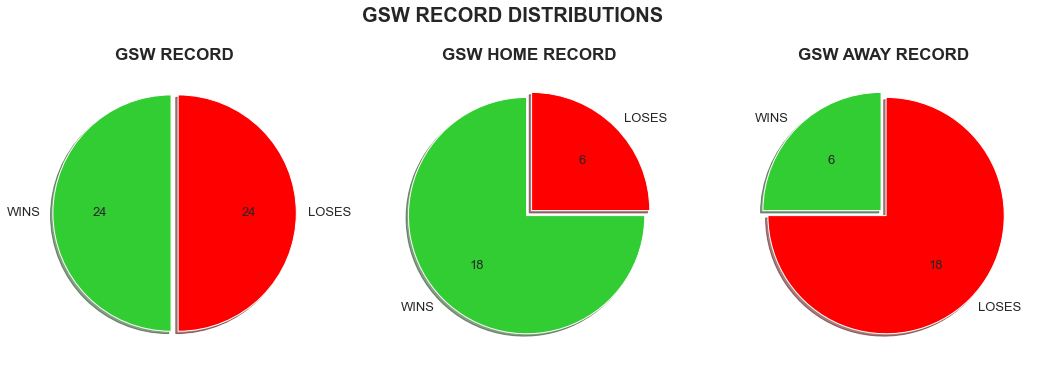

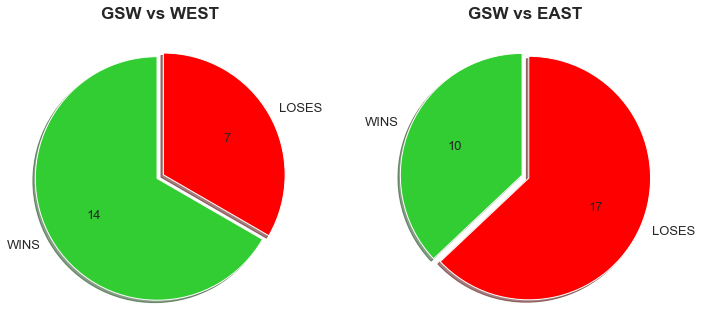

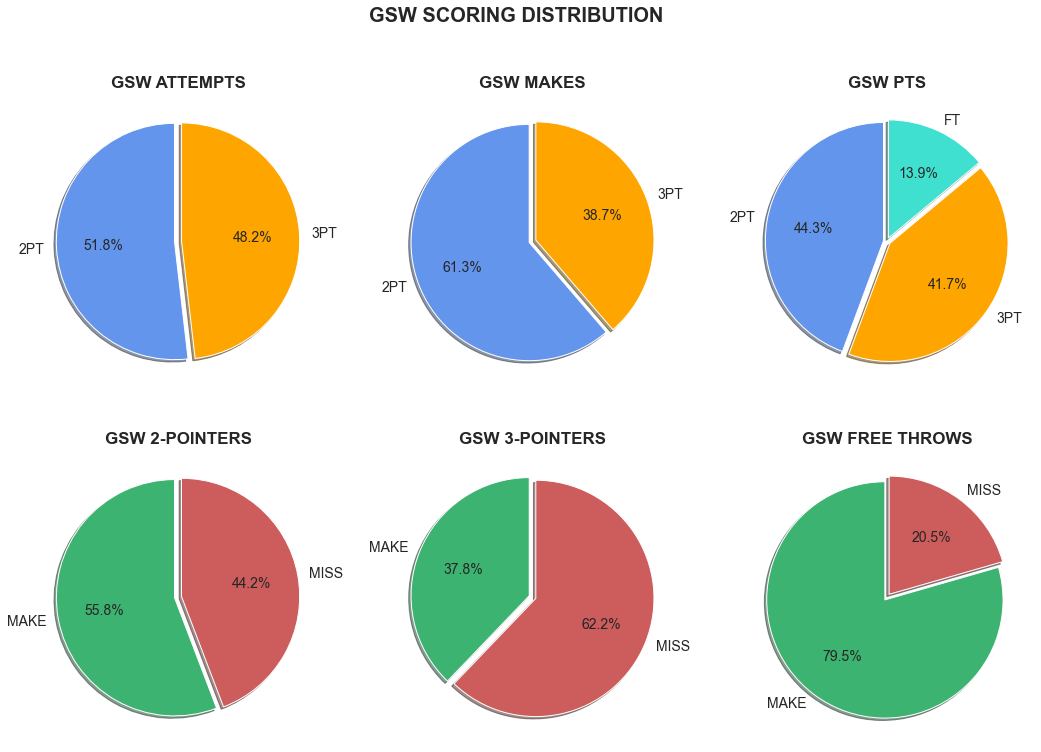

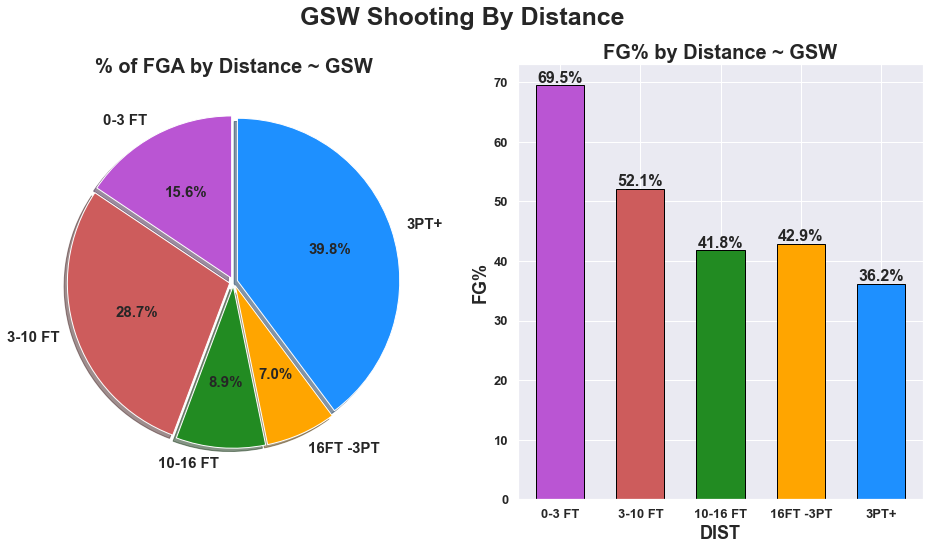

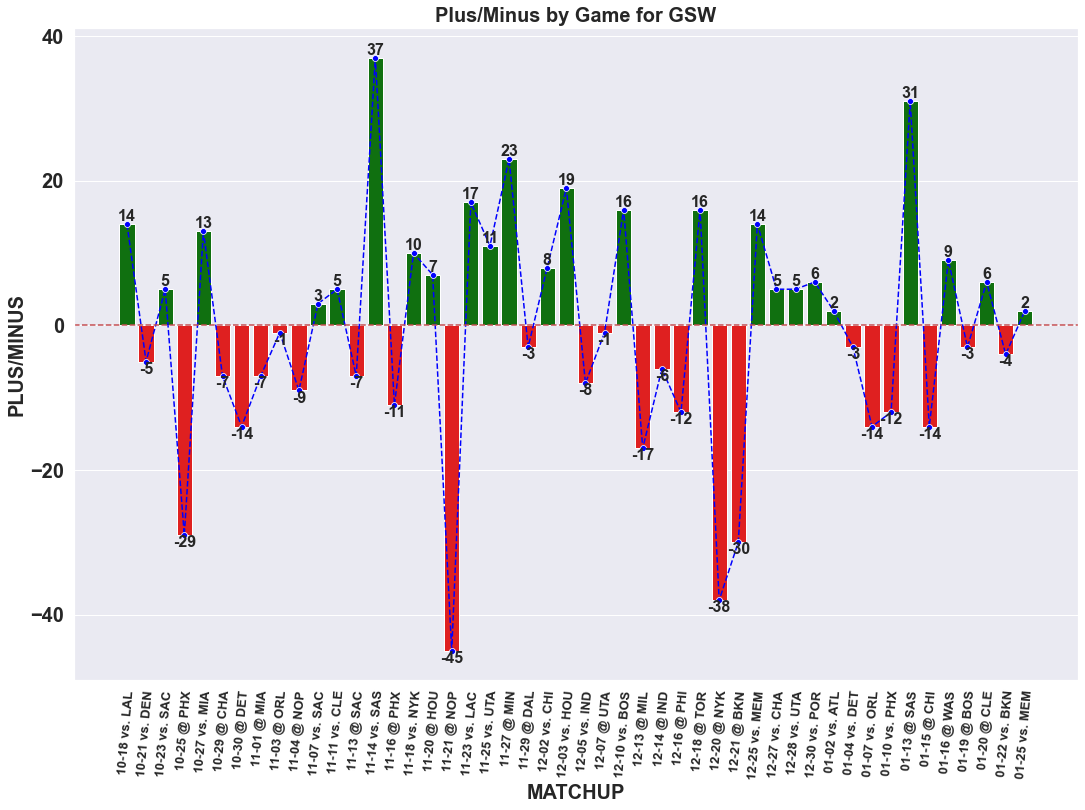

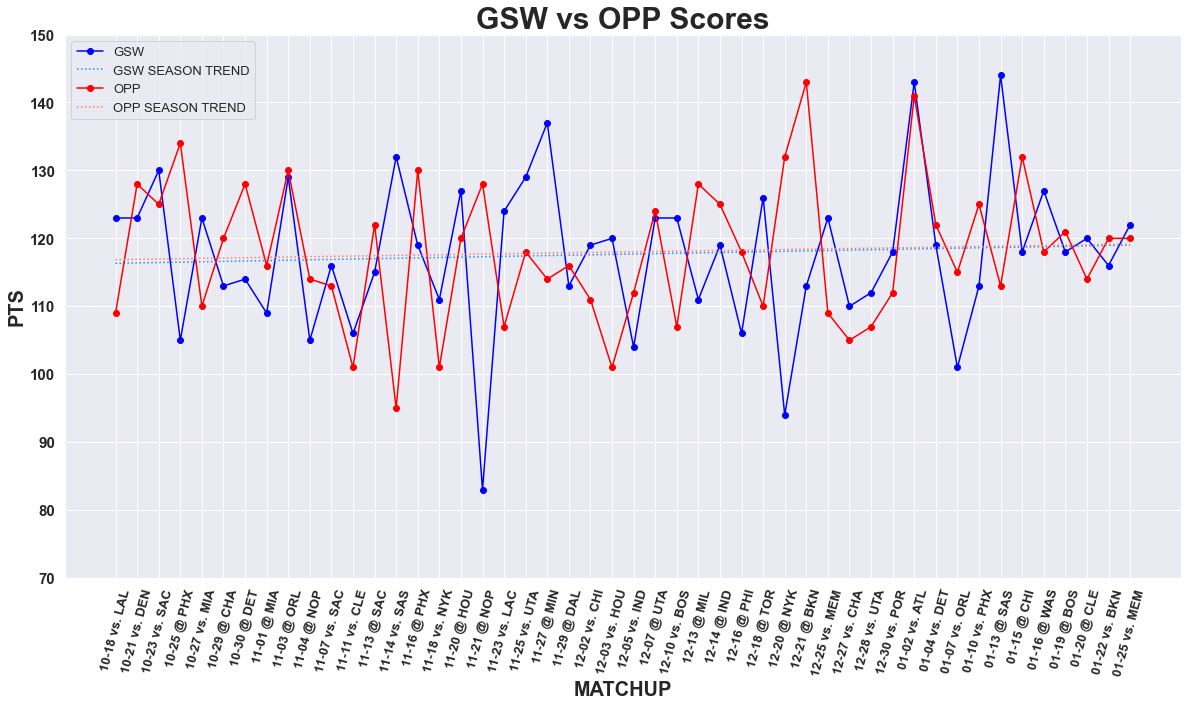

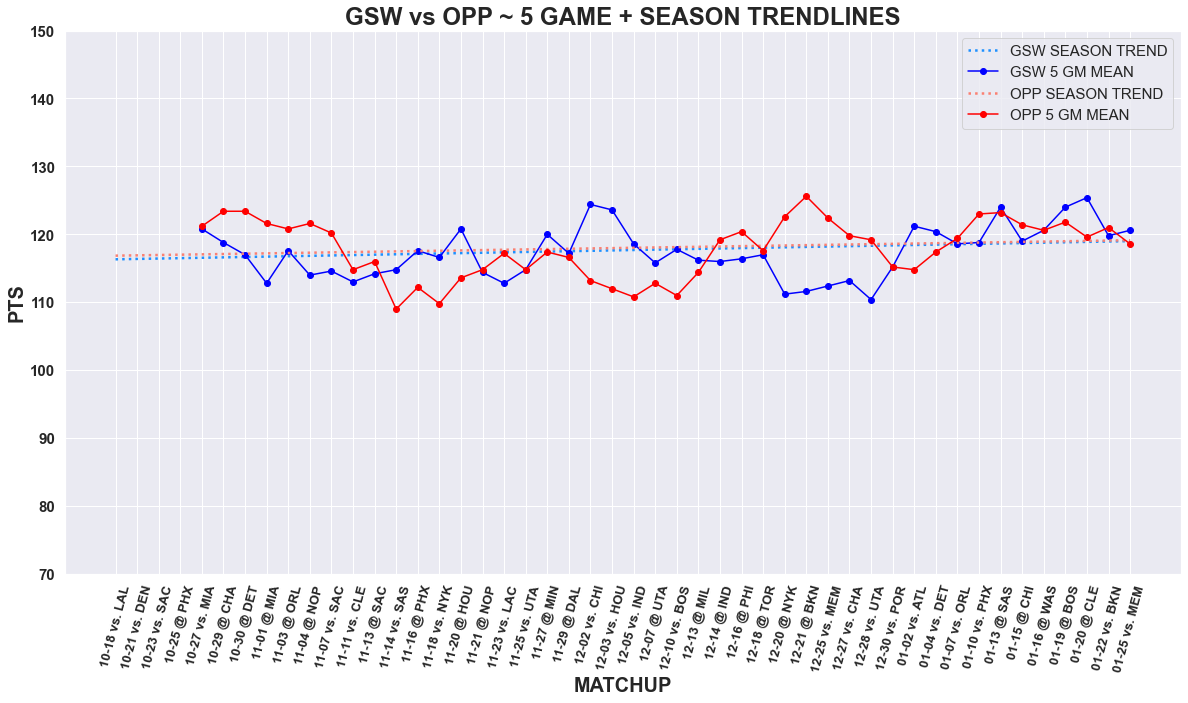

In [205]:
#NBA TEAM REPORT

def team_report(team_abbr):
    wl_pies(team_abbr)
    shot_pies(team_abbr)
    team_fg_by_dist(team_abbr)
    plus_minus_plot(team_abbr)
    line_plot_scores(team_abbr)
    trend_plot_scores(team_abbr)
    
team_report("GSW")

# 2-Team Comparison Function

10 Game Gaussian Simulations
DEN Win%:  0.7
TOR Win%:  0.3
Tie%:  0.0

100 Game Gaussian Simulations
DEN Win%:  0.6
TOR Win%:  0.37
Tie%:  0.03

1000 Game Gaussian Simulations
DEN Win%:  0.529
TOR Win%:  0.425
Tie%:  0.046



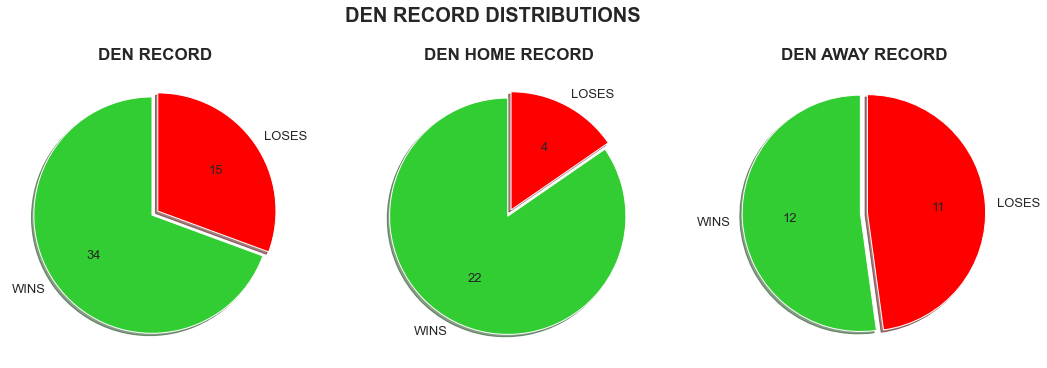

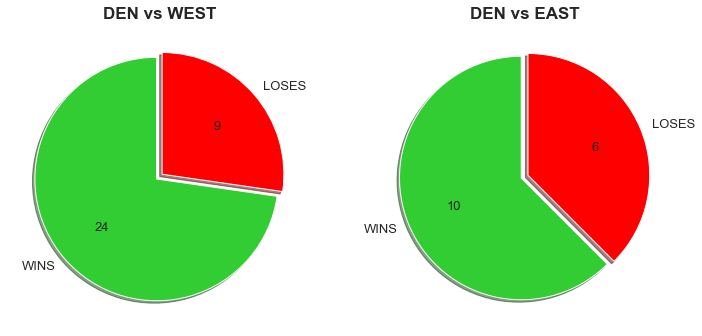

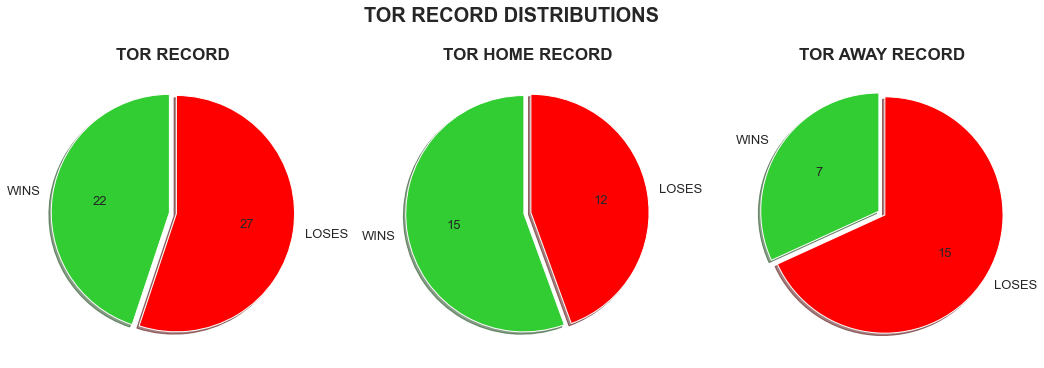

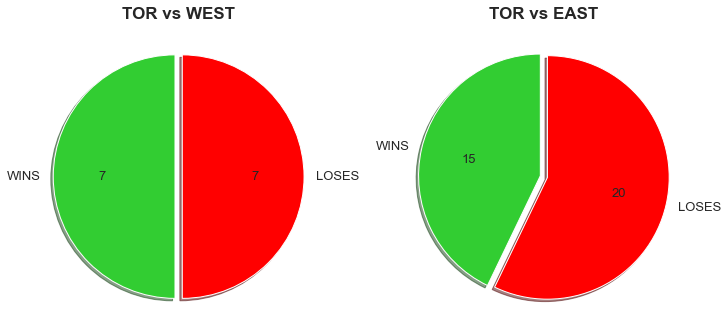

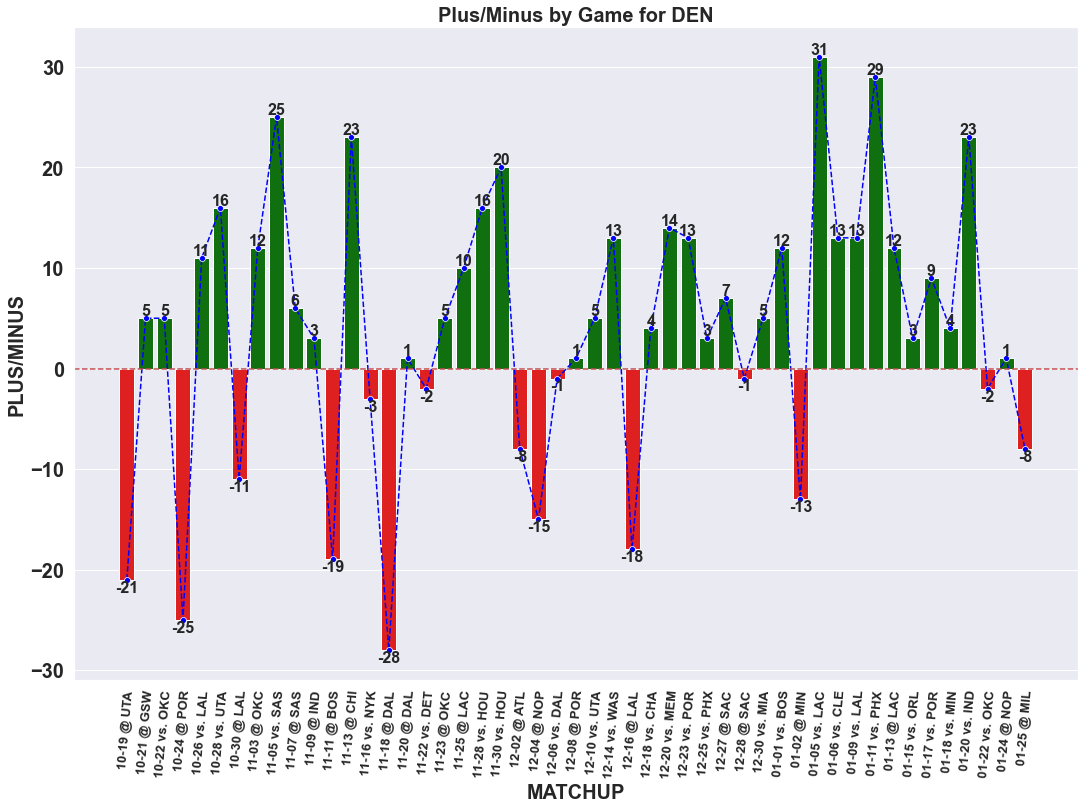

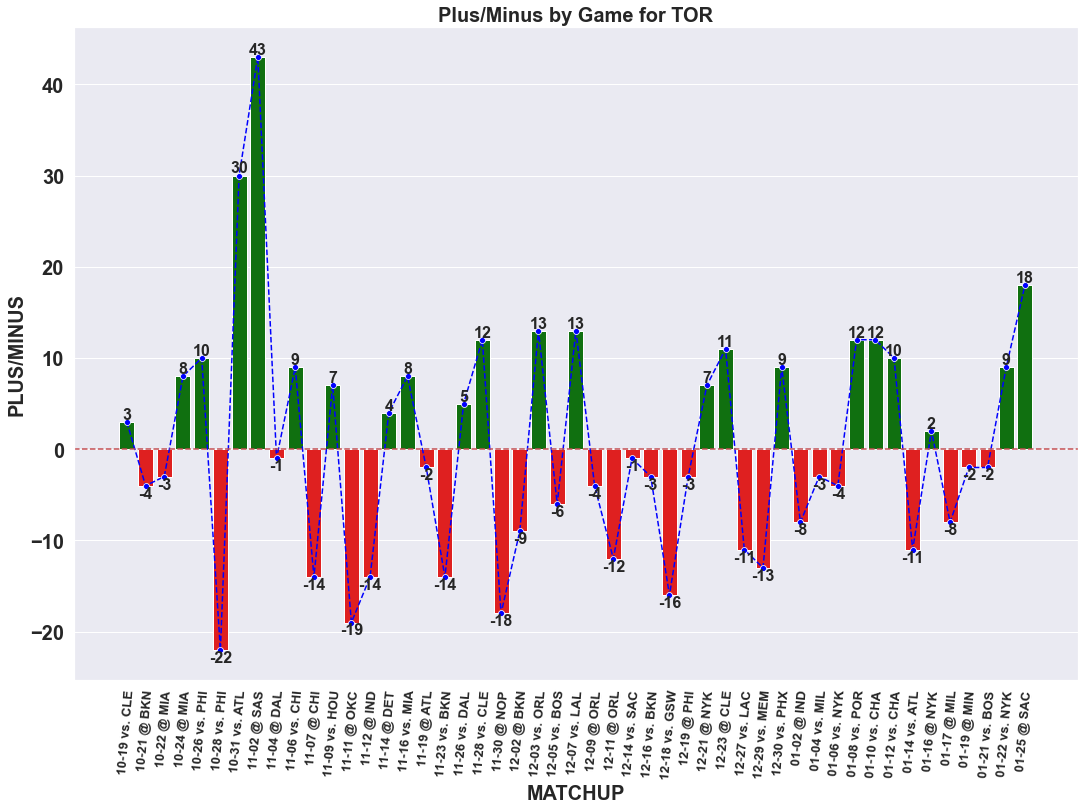

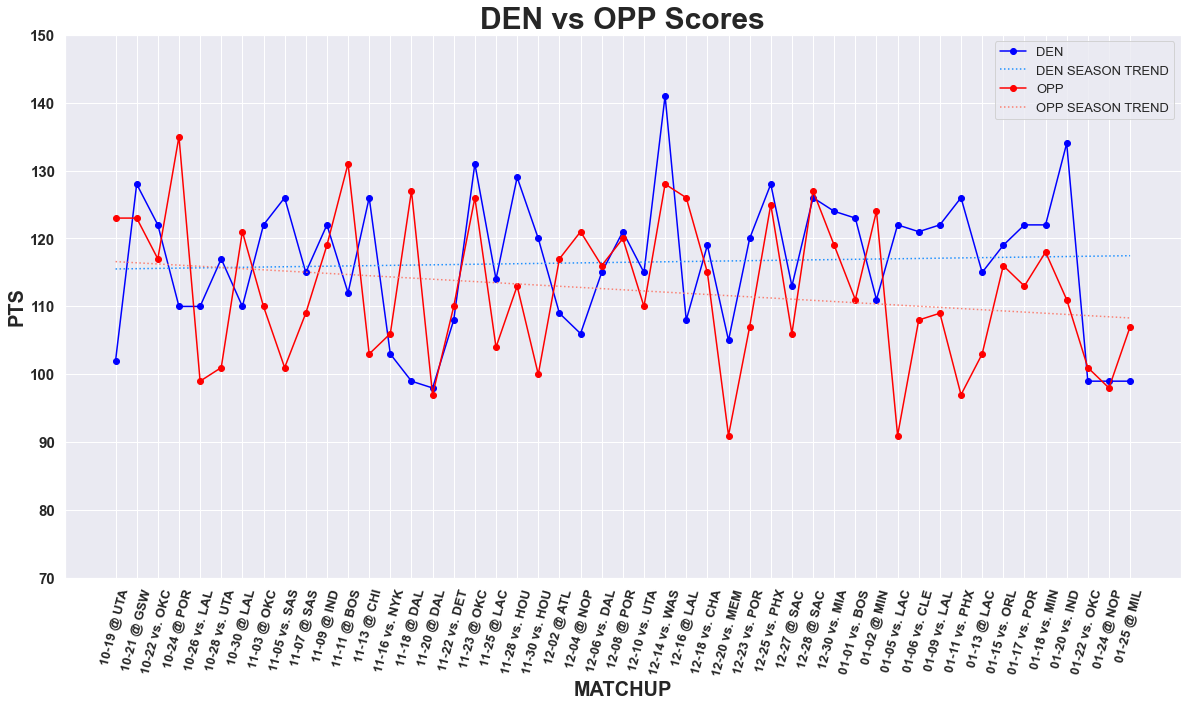

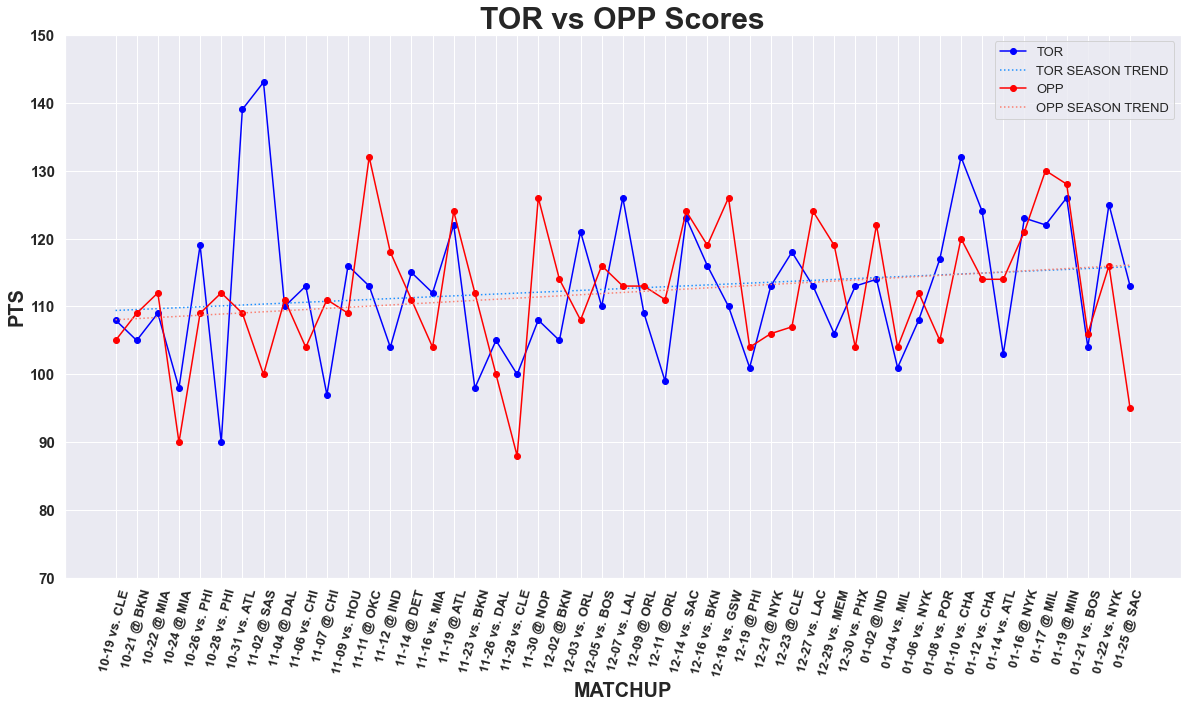

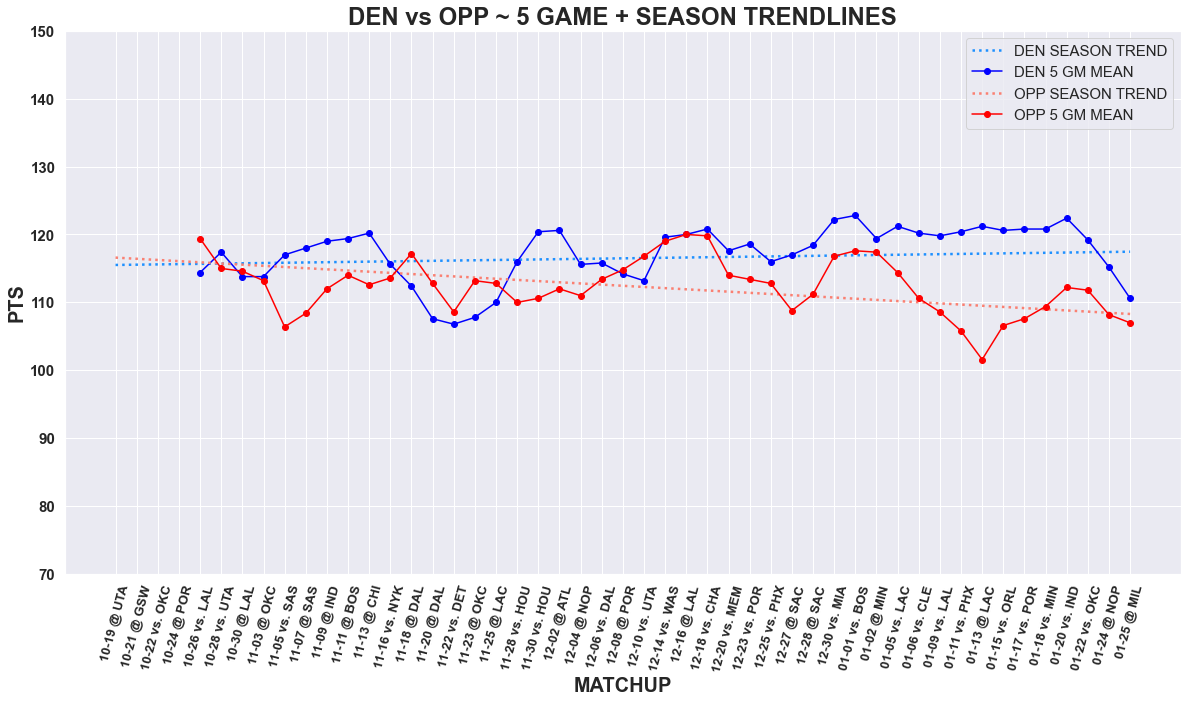

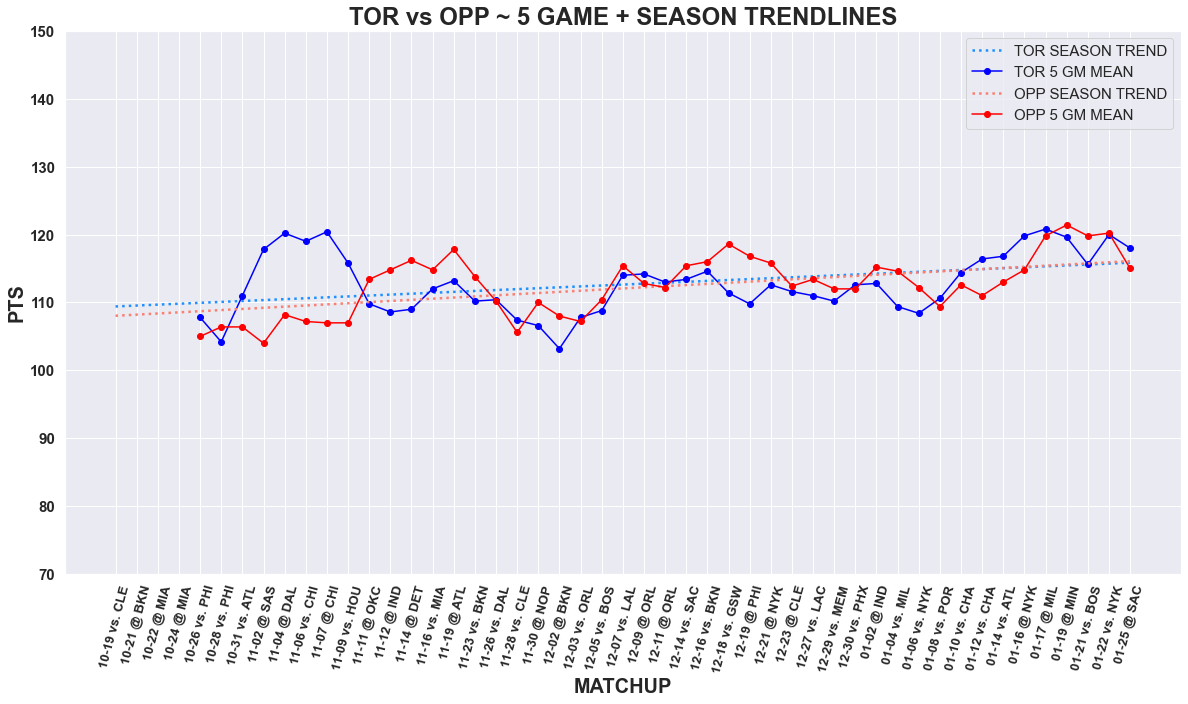

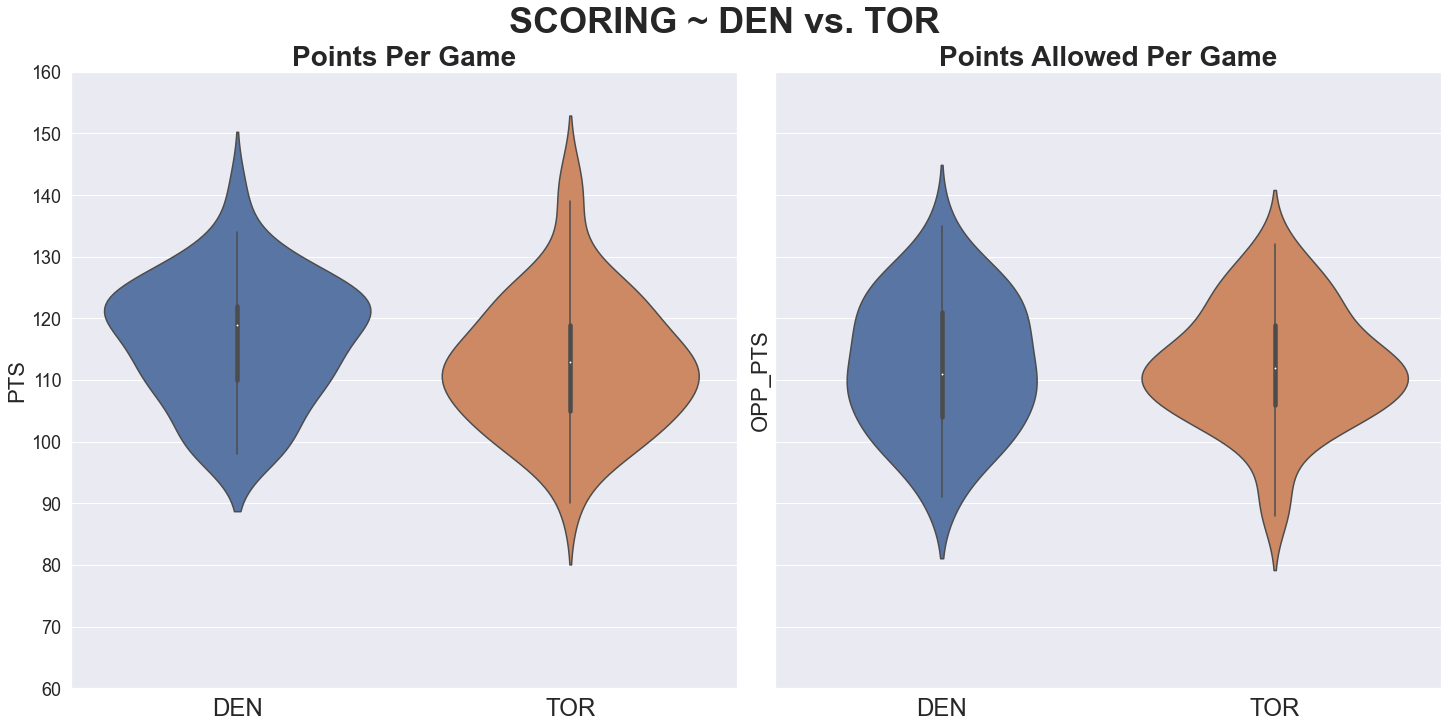

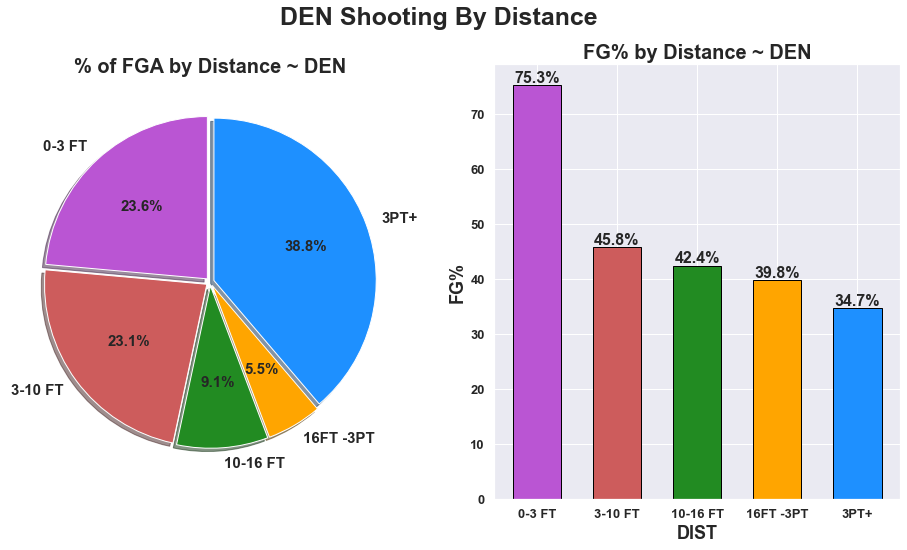

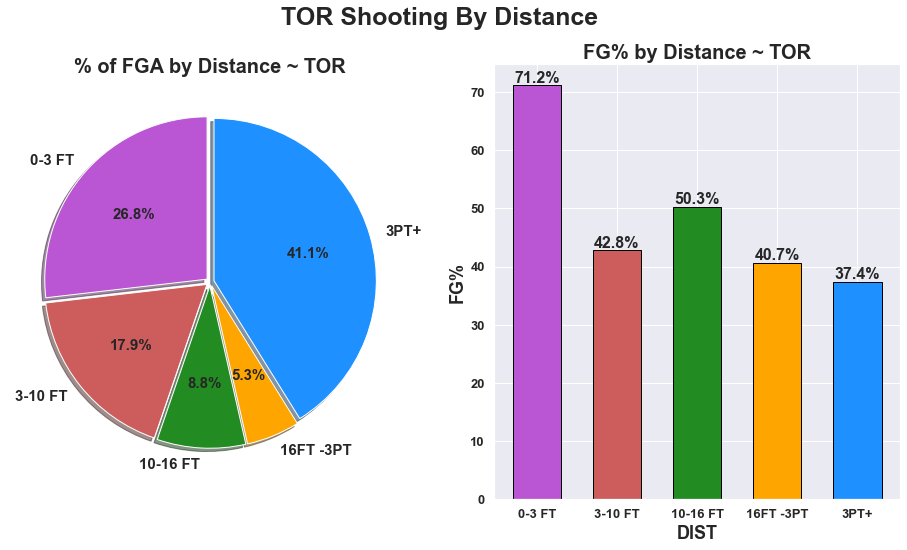

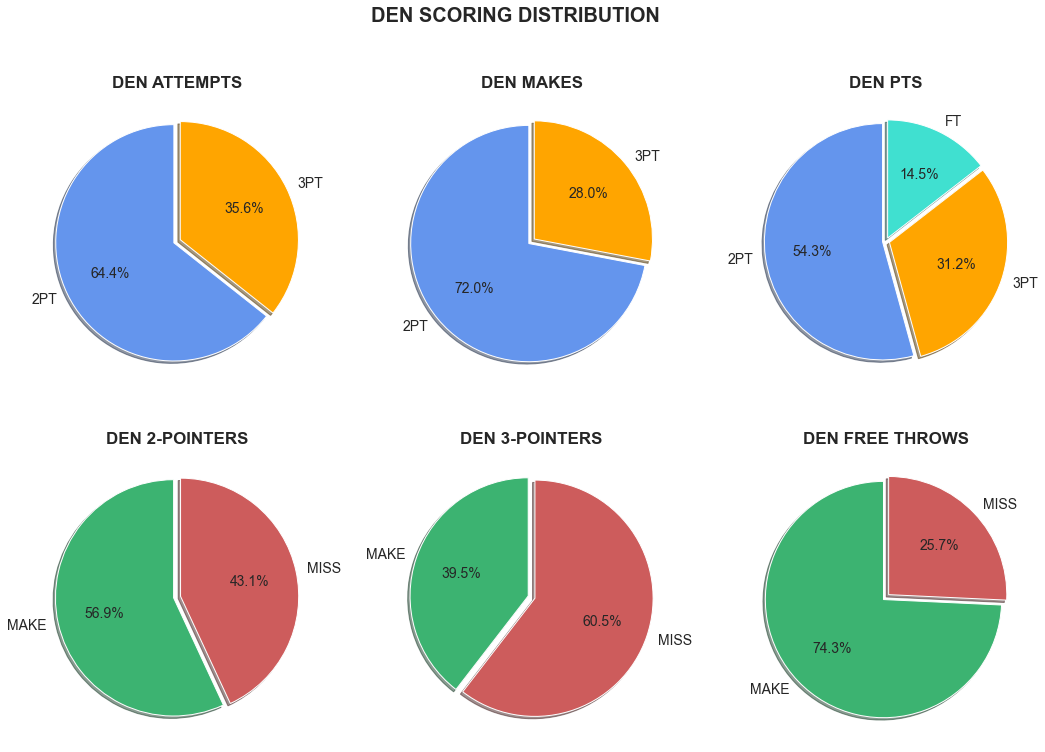

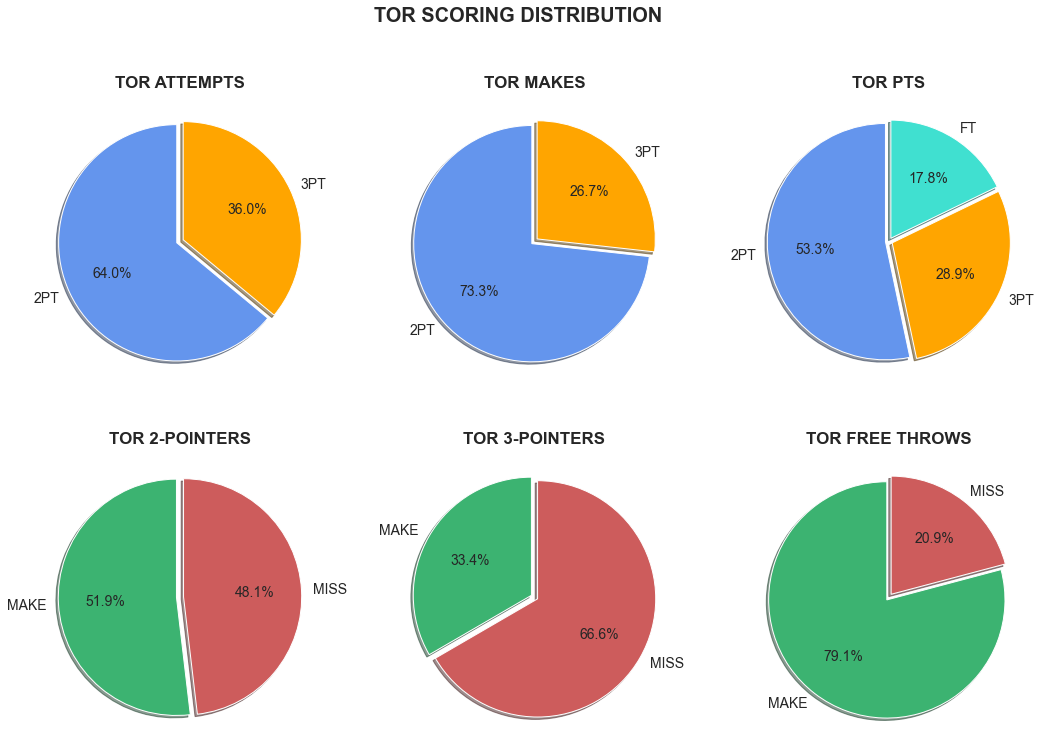

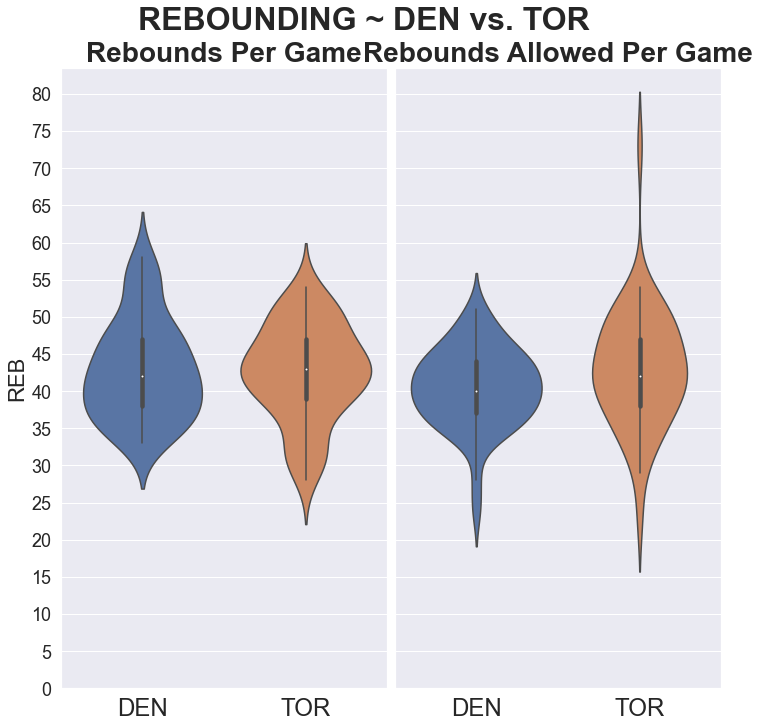

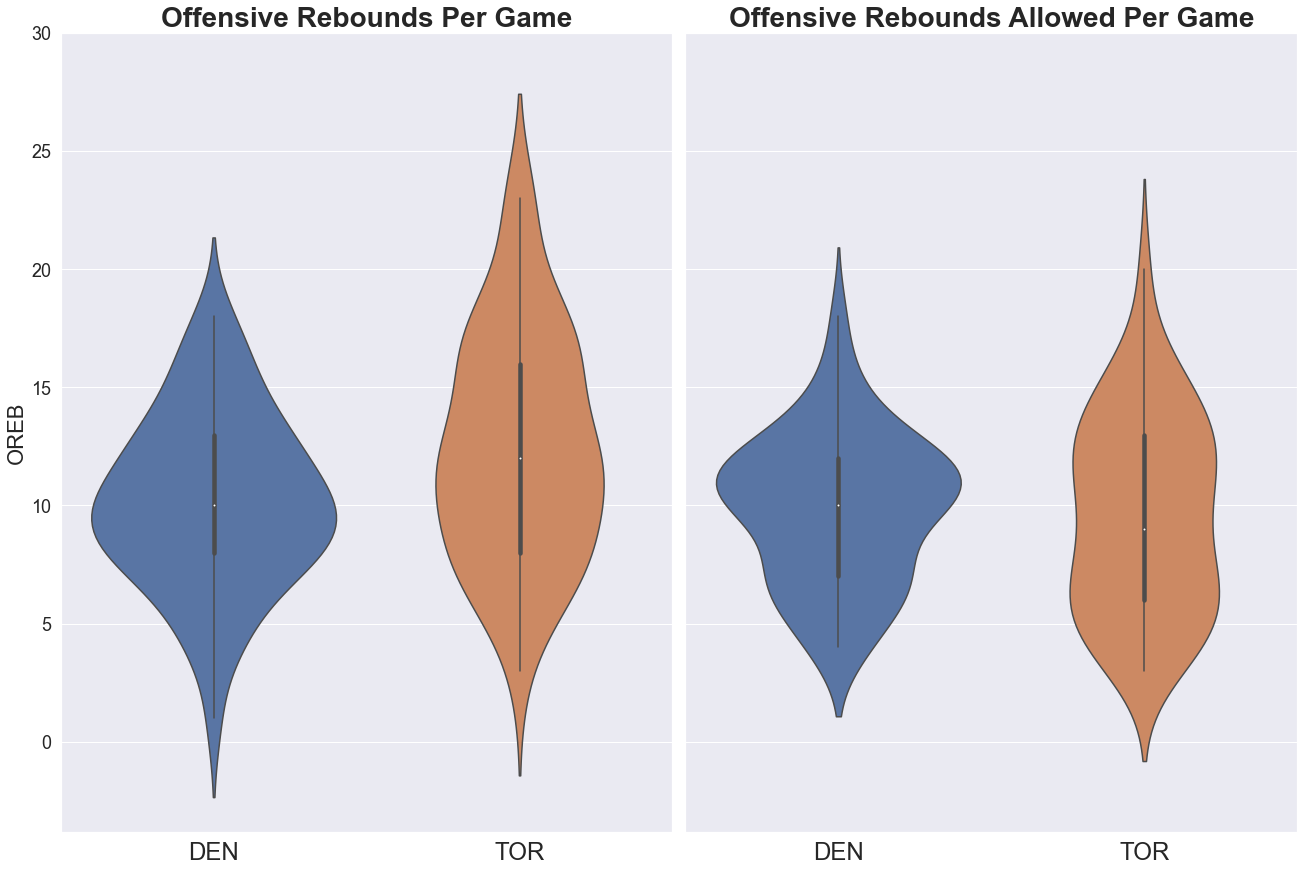

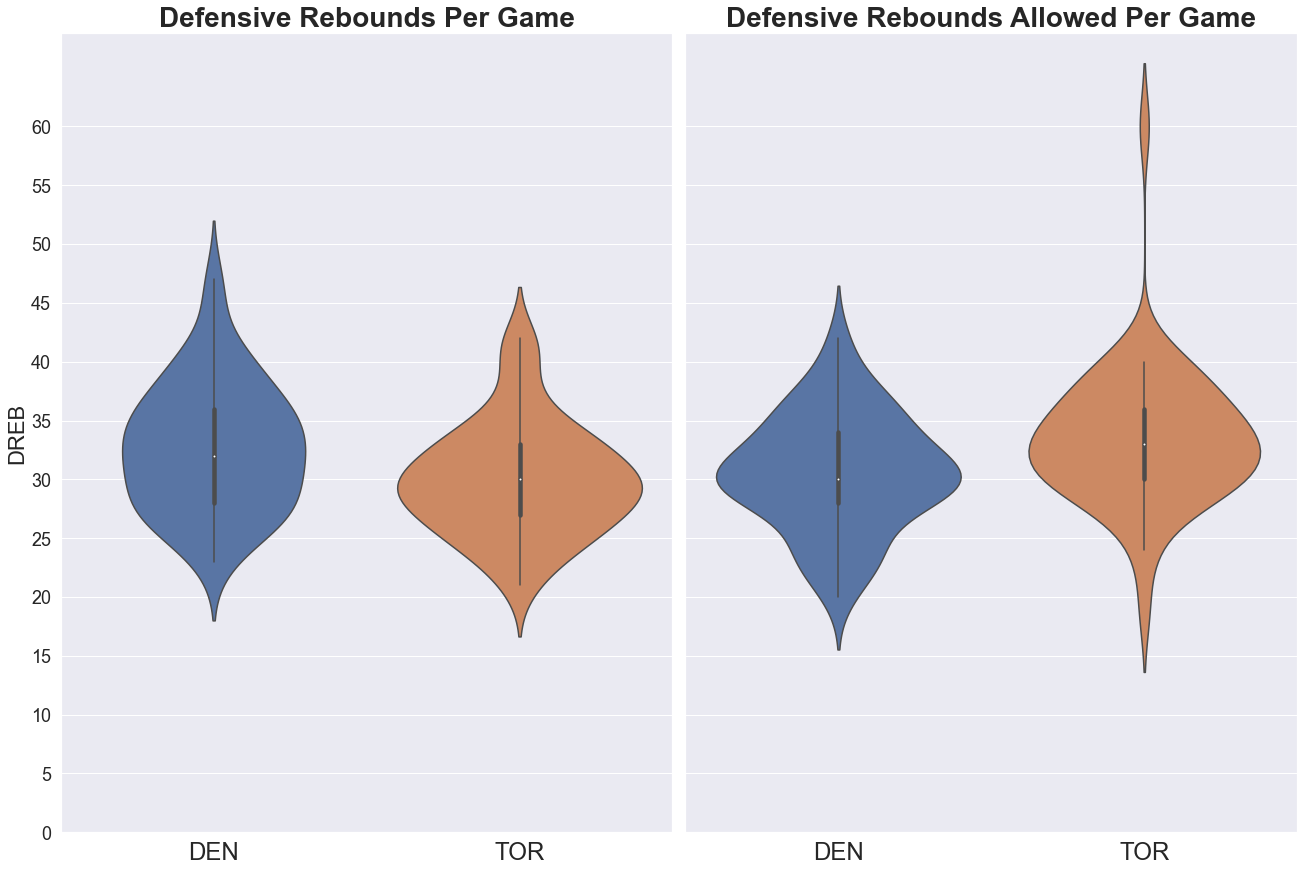

In [204]:
def compare_teams(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])
    
    game_simulations(10,team_a_abbr,team_b_abbr)
    game_simulations(100,team_a_abbr,team_b_abbr)
    game_simulations(1000,team_a_abbr,team_b_abbr)
    
    wl_pies(team_a_abbr)
    wl_pies(team_b_abbr)
    
    plus_minus_plot(team_a_abbr)
    plus_minus_plot(team_b_abbr)
    
    line_plot_scores(team_a_abbr)
    line_plot_scores(team_b_abbr)
    
    trend_plot_scores(team_a_abbr)
    trend_plot_scores(team_b_abbr)
    
    scored_allowed_compare(team_a_abbr, team_b_abbr)
    
    team_fg_by_dist(team_a_abbr)
    team_fg_by_dist(team_b_abbr)
    
    shot_pies(team_a_abbr)
    shot_pies(team_b_abbr)
    
    rebounds_compare(team_a_abbr, team_b_abbr)
    
    plt.show()

compare_teams('DEN','TOR')

## NBA All Team Comparison Report

In [30]:
def NBA_team_leaders():
    for i in df.drop(columns=['TEAM_ID','MIN','MONTH','YEAR']).columns:
        if is_numeric_dtype(df[i])==True:
            if i[0:4] !='FRAC':
                NBA_stat_boxplots(i, asc=False)
            
#NBA_team_leaders()